In [4]:
import pandas as pd
import numpy as np
data = pd.read_csv('sp500.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,03-01-00,1469.250000,1478.000000,1438.359985,1455.219971,931800000
1,04-01-00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000
2,05-01-00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000
3,06-01-00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000
4,07-01-00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000


In [5]:
data = data.iloc[:,1:6]
data = data.values.astype(float)
data = pd.DataFrame(data)
data = data.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
print(data[:3])

          0         1         2         3         4
0 -0.005973 -0.005916 -0.015676 -0.012310 -0.191184
1 -0.012266 -0.016172 -0.034017 -0.037249 -0.184230
2 -0.037292 -0.035058 -0.042867 -0.036047 -0.177338


可以将上述读取股票数据的代码用一个函数表示：

In [6]:
import pandas as pd
import numpy as np

def read_stock(filename,normalize = True):    
    data = pd.read_csv(filename)
    data = data.iloc[:,1:6]
    data = data.values.astype(float)
    data = pd.DataFrame(data)   
    if normalize:
        data = data.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
        return data

data = read_stock('sp500.csv')
print(data[:3])

          0         1         2         3         4
0 -0.005973 -0.005916 -0.015676 -0.012310 -0.191184
1 -0.012266 -0.016172 -0.034017 -0.037249 -0.184230
2 -0.037292 -0.035058 -0.042867 -0.036047 -0.177338


下面的代码绘制收盘价的曲线：

(4697,)


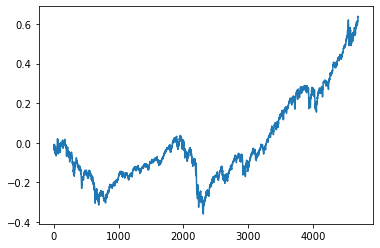

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array(data.iloc[:,-2])
print(x.shape)
plt.plot(x)
plt.show()

### 7.1.4  生成自回归数据

下面的代码通过正弦函数和余弦函数的组合成一个函数，然后采样该函数曲线的y坐标值构成一个序列数据：

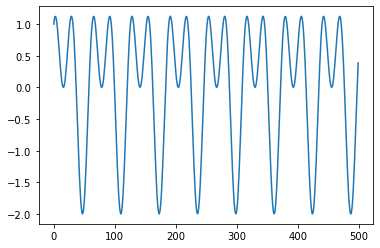

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_seq_data_from_function(f,ts):
    return f(ts)

T  =5000
x = gen_seq_data_from_function(lambda ts:np.sin(ts*0.1)+np.cos(ts*0.2),\
                               np.arange(0, T))
plt.plot(x[:500])
plt.show()

根据公式：
$$x_t = a_0+a_1 x_{t-1}+\cdots+ a_{\tau}x_{t-\tau} + \epsilon \tag{7-4}$$
生存自回归数据。

对自回归模型的研究表明，只有当系数构成的方程$x^{\tau}-a_0x^{\tau-1}-a_1x^{\tau-2}-\cdots-a_{\tau}$的根的绝对值不超过1时，这个自回归模型才是稳定的，否则，生成的数据是不稳定的。

函数init_coefficients()生成稳定的自回归模型的系数：

In [9]:
np.random.seed(5)
def init_coefficients(n):
    while True:
        a = np.random.random(n) - 0.5
        coefficients = np.append(1, -a)       
        if np.max(np.abs(np.roots(coefficients))) < 1:
            return a
init_coefficients(3)

array([-0.27800683,  0.37073231, -0.29328084])

6


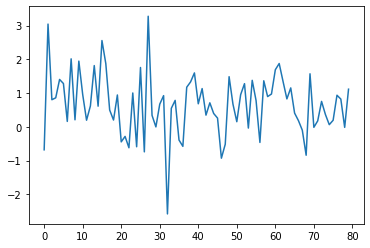

In [10]:
def generate_data(n,data_n,noise_value = 1,k=3):   
    a = init_coefficients(n+1)   
    x = np.zeros(data_n + n*(k+1))
    x_noise = np.zeros(data_n + n*(k+1))
    x_noise[:n]= np.random.randn(n)   
    print(len(a))
    
    n_all = data_n + n*k
    for i in range(n_all):        
        x[n+i] = np.dot(x_noise[i:n+i][::-1], a[1:]) +a[0] 
        x_noise[n+i] = x[n+i] + noise_value * np.random.randn() 
       
    x_noise = x_noise[k*n:] #舍弃前面的k*n个实数
    x = x[k*n:]
    return x_noise,x

x,x_noise = generate_data(5,100)
plt.plot(x[:80])
plt.show()

### 7.1.6  时间窗采样

In [11]:
np.random.seed(0)
def gen_data_set(x,T,percentage = 0.9):
    L = T + 1
    data_set = []
    for i in range(len(x) - (T+1)):
        data_set.append(x[i: i + T+1])
    data_set = np.array(data_set)
    row = round(percentage * data_set.shape[0])
    train = data_set[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = data_set[int(row):, :-1]
    y_test = data_set[int(row):, -1]
    return [x_train, y_train, x_test, y_test]

In [12]:
x = gen_seq_data_from_function(lambda ts:np.sin(ts*0.1)+np.cos(ts*0.2),\
                               np.arange(0, 5000))
x_train, y_train, x_test, y_test = gen_data_set(x, 50)

y_train = y_train.reshape(-1,1)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4454, 50) (4454, 1)
(495, 50) (495,)


### 7.1.7   时间窗方法建模和训练

从自回归序列数据按照固定时间窗采样得到训练样本，就可以用监督式学习模型对其进行建模与训练。下面的代码用一个2层全连接神经网络对上述从函数值采样的自回归数据进行建模与训练：

n 50
[    1, 1] loss: 2.711
[  101, 5] loss: 0.331
[  201, 10] loss: 0.137
[  301, 14] loss: 0.109
[  401, 19] loss: 0.100


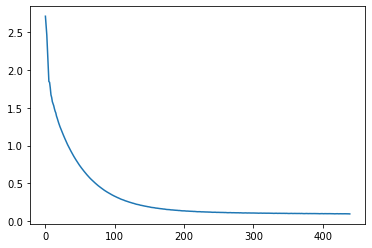

In [13]:
from NeuralNetwork import *
from train import *
import util

hidden_dim = 50
n = x_train.shape[1]
print("n",n)
nn = NeuralNetwork()
nn.add_layer(Dense(n, hidden_dim)) #('xavier',0.01)))
nn.add_layer(Relu())
nn.add_layer(Dense(hidden_dim, 1)) #('xavier',0.01)))

learning_rate = 1e-2
momentum = 0.8 #0.9
optimizer = SGD(nn.parameters(),learning_rate,momentum)

epochs=20
batch_size = 200 # len(train_x) #200   
reg = 1e-1
print_n=100

losses = train_nn(nn,x_train,y_train,optimizer,
                  util.mse_loss_grad,epochs,batch_size,reg,print_n)
#print(losses[::len(losses)//50])
plt.plot(losses)

### 7.1.8   长期预测和短期预测

##### 长期预测

从初始时刻的真实数据样本预测后续一系列时刻的数据。并将这些预测值与测试集对应的目标值进行可视化比较。以观察这个模型的预测性能。

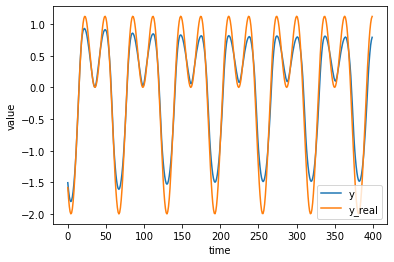

In [14]:
x = x_test[0].copy()
x = x.reshape(1,-1)
ys =[]
for i in range(400):
    y = nn.forward(x)   
    ys.append(y[0][0])
    x = np.delete(x,0,1)
    x = np.append(x, y.reshape(1,-1), axis=1)    
ys  = ys[:]
plt.plot(ys[:400])
plt.plot(y_test[:400])
plt.xlabel("time")
plt.ylabel("value")
plt.legend(['y','y_real'])

#### 短期预测

下面的代码是用训练的神经网络进行短期预测，即每次都是用真实数据预测其下一个时刻的数据值：

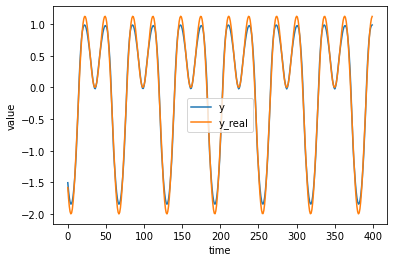

In [15]:
ys =[]
for i in range(400):
    x = x_test[i].copy()
    x = x.reshape(1,-1)
    y = nn.forward(x)   
    ys.append(y[0][0])   
ys  = ys[:]
plt.plot(ys[:400])
plt.plot(y_test[:400])
plt.xlabel("time")
plt.ylabel("value")
plt.legend(['y','y_real']

### 7.1.9 股票价格预测 
下面代码用时间窗为100生成训练数据集和测试数据集，即用前100天的价格预测后一天的价格

In [16]:
data = read_stock('sp500.csv')
x = np.array(data.iloc[:,-2])
print(x.shape)
x = x.reshape(-1,1)
print(x.shape)

x_train, y_train, x_test, y_test = gen_data_set(x, 100)
y_train = y_train.reshape(-1,1)
print(x_train.shape,y_train.shape)

(4697,)
(4697, 1)
(4136, 100, 1) (4136, 1)


用训练集训练一个神经网络模型：

n 100
0 iter: 0.017707950694492998
50 iter: 0.0005195455067102583
100 iter: 0.0004480920043512021
150 iter: 0.0003970824499375024
200 iter: 0.00038526671247368687
250 iter: 0.00035665095175022217
300 iter: 0.00034418856474243
350 iter: 0.0003279284024790593
400 iter: 0.0003265784924812387
450 iter: 0.000313850363498057


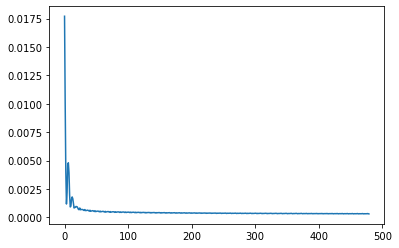

In [17]:
from NeuralNetwork import *
import util

hidden_dim = 500
n = x_train.shape[1]
print("n",n)
nn = NeuralNetwork()
nn.add_layer(Dense(n, hidden_dim))
nn.add_layer(Relu())
nn.add_layer(Dense(hidden_dim, 1)) 

learning_rate = 0.1
momentum = 0.8 #0.9
optimizer = SGD(nn.parameters(),learning_rate,momentum)

epochs=60
batch_size = 500 # len(train_x) #200   
reg = 1e-6
print_n=50

losses = train_nn(nn,x_train,y_train,optimizer,util.mse_loss_grad,epochs,batch_size,reg,print_n)
plt.plot(losses)

用测试集的第一个样本作为开始，进行长期预测，即不断用预测值构建新的数据特征去预测下一天的股票价格：

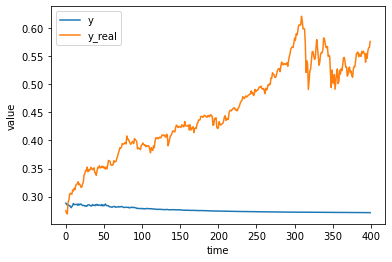

In [18]:
x = x_test[0].copy()
x = x.reshape(1,-1)
ys =[]

num = 400
for i in range(num):
    y = nn.forward(x)    
    ys.append(y[0][0])
    x = np.delete(x,0,1)
    x = np.append(x, y.reshape(1,-1), axis=1)    
ys  = ys[:]
plt.plot(ys[:num])
plt.plot(y_test[:num])
plt.xlabel("time")
plt.ylabel("value")
plt.legend(['y','y_real'])

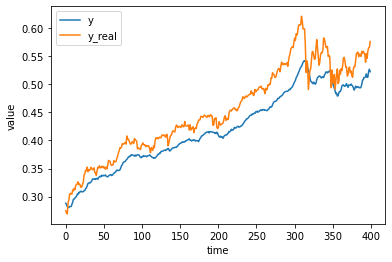

In [19]:
ys =[]
num = 400
for i in range(num):
    x = x_test[i].copy()
    x = x.reshape(1,-1)
    y = nn.forward(x) 
    ys.append(y[0][0])
    x = np.delete(x,0,1)
    x = np.append(x, y.reshape(1,-1), axis=1)    
ys  = ys[:]
plt.plot(ys[:num])
plt.plot(y_test[:num])
plt.xlabel("time")
plt.ylabel("value")
plt.legend(['y','y_real'])

## 7.4 单层循环神经网络的实现
### 7.4.1 初始化模型参数

In [20]:
import numpy as np
np.random.seed(1)
def rnn_params_init(input_dim, hidden_dim,output_dim,scale = 0.01):        
    Wx = np.random.randn(input_dim, hidden_dim)*scale # input to hidden
    Wh = np.random.randn(hidden_dim, hidden_dim)*scale # hidden to hidden
    bh = np.zeros((1,hidden_dim)) # hidden bias

    Wf = np.random.randn(hidden_dim, output_dim)*scale # hidden to output        
    bf = np.zeros((1,output_dim)) # output bias

    return [Wx,Wh,bh,Wf,bf]  

In [21]:
def rnn_hidden_state_init(batch_dim, hidden_dim):
    return np.zeros((batch_dim,hidden_dim))

### 7.4.2 正向计算

In [22]:
def rnn_forward(params,Xs, H_):
    Wx, Wh, bh, Wf, bf = params
    H = H_ #np.copy(H_)   
   
    Fs = []        
    Hs = {}      
    Hs[-1] = np.copy(H)    
 
    for t  in range(len(Xs)):
        X = Xs[t]       
        H = np.tanh(np.dot(X, Wx) + np.dot(H, Wh) + bh)
        F = np.dot(H, Wf) + bf       

        Fs.append(F)
        Hs[t] = H
    return Fs, Hs

In [23]:
def rnn_forward_step(params,X, preH):
    Wx, Wh, bh, Wf, bf = params     
    H = np.tanh(np.dot(X, Wx) + np.dot(preH, Wh) + bh)
    F = np.dot(H, Wf) + bf 
    return F, H

In [24]:
def rnn_forward_(params,Xs, H_):
    Wx, Wh, bh, Wf, bf = params
    H = H_  
   
    Fs = []        
    Hs = {}      
    Hs[-1] = np.copy(H)    
 
    for t  in range(len(Xs)):
        X = Xs[t]       
        F,H = rnn_forward_step(params,X,H)       
        Fs.append(F)
        Hs[t] = H
    return Fs, Hs

### 7.4.3 损失函数

In [25]:
import util
def rnn_loss_grad(Fs,Ys,loss_fn = util.cross_entropy_grad_loss,flatten = True):   
    loss = 0
    dFs = {}
   
    for t in range(len(Fs)):
        F = Fs[t]
        Y = Ys[t]   
        if flatten and Y.ndim>=2:          
            Y = Y.flatten()
        loss_t,dF_t = loss_fn(F,Y)
        loss += loss_t        
        dFs[t] = dF_t
       
    return loss,dFs

### 7.4.4 反向求导

In [26]:
import math
def grad_clipping(grads,alpha):
    norm = math.sqrt(sum((grad ** 2).sum() for grad in grads))
    if norm > alpha:
        ratio = alpha / norm
        for i in range(len(grads)):
            grads[i]*=ratio 
            
def rnn_backward(params,Xs,Hs,dZs,clip_value = 5.): # Ys,loss_function):    
    Wx, Wh,bh, Wf,bf = params
    dWx, dWh, dWf = np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(Wf)
    dbh, dbf = np.zeros_like(bh), np.zeros_like(bf)       

    dh_next = np.zeros_like(Hs[0])
    h = Hs
    x = Xs
    
    T = len(Xs)  #序列长度（时刻长度）  
    for t in reversed(range(T)): 
        dZ = dZs[t]        
        
        dWf += np.dot(h[t].T,dZ)
    
        dbf += np.sum(dZ, axis=0, keepdims=True)         
        dh = np.dot(dZ, Wf.T) + dh_next 
        dZh = (1 - h[t] * h[t]) * dh 
        
        dbh += np.sum(dZh, axis=0, keepdims=True) 
        dWx += np.dot(x[t].T,dZh)
        dWh += np.dot(h[t-1].T,dZh)
        dh_next = np.dot(dZh,Wh.T)
   
    grads =  [dWx, dWh, dbh,dWf, dbf]
    if clip_value is not None:
        grad_clipping(grads,clip_value)
    return grads

In [27]:
def rnn_backward_step(params,dZ,X,H,H_,dh_next): 
    Wx, Wh,bh, Wf,bf = params
    dWf = np.dot(H.T,dZ)

    dbf = np.sum(dZ, axis=0, keepdims=True)         
    dh = np.dot(dZ, Wf.T) + dh_next 
    dZh = (1 - H * H) * dh 

    dbh = np.sum(dZh, axis=0, keepdims=True) 
    dWx = np.dot(X.T,dZh)
    dWh = np.dot(H_.T,dZh)
    dh_next = np.dot(dZh,Wh.T)
    return dWx, dWh,dbh, dWf,dbf,dh_next

In [28]:
def rnn_backward_(params,Xs,Hs,dZs,clip_value = 5.): 
    Wx, Wh,bh, Wf,bf = params
    dWx, dWh, dWf = np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(Wf)
    dbh, dbf = np.zeros_like(bh), np.zeros_like(bf)
    dh_next = np.zeros_like(Hs[0])
    
    T = len(Xs)  #序列长度（时刻长度）  
    for t in reversed(range(T)):  
        dZ = dZs[t] 
        H= Hs[t]
        H_ = Hs[t-1]
        X = Xs[t]
        
        dWx_,dWh_,dbh_,dWf_,dbf_,dh_next = rnn_backward_step(params,dZ,X,H,H_,dh_next)
        for grad,grad_t in zip([dWx, dWh,dbh, dWf,dbf],[dWx_,dWh_,dbh_,dWf_,dbf_]):
            grad+=grad_t      

    grads =  [dWx, dWh, dbh,dWf, dbf]
    if clip_value is not None:
    	grad_clipping(grads,clip_value)
    return grads   

### 7.4.5  梯度验证

In [29]:
import numpy as np
np.random.seed(1)

#生成4个时刻，每批有2个样本的一批样本Xs及目标
#定义一个输入、隐含层、输出层的大小分别是4、10、4的RNN模型
if True:
    T  = 5
    input_dim, hidden_dim,output_dim = 4,10,4
    batch_size = 1
    seq_len = 5
    Xs = np.random.rand(seq_len,batch_size,input_dim)
    #Ys = np.random.randint(input_dim,size = (seq_len,batch_size,output_dim))
    Ys = np.random.randint(input_dim,size = (seq_len,batch_size))
    
print(Xs)
print(Ys)

[[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01]]

 [[1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01]]

 [[3.96767474e-01 5.38816734e-01 4.19194514e-01 6.85219500e-01]]

 [[2.04452250e-01 8.78117436e-01 2.73875932e-02 6.70467510e-01]]

 [[4.17304802e-01 5.58689828e-01 1.40386939e-01 1.98101489e-01]]]
[[1]
 [1]
 [1]
 [3]
 [3]]


下面代码计算上述样本的分析梯度：

In [30]:
# --------cheack gradient-------------   
params = rnn_params_init(input_dim, hidden_dim,output_dim)
H_0 = rnn_hidden_state_init(batch_size,hidden_dim)

Fs,Hs = rnn_forward(params,Xs,H_0) 
loss_function = rnn_loss_grad
print(Fs[0].shape,Ys[0].shape)
loss,dFs = loss_function(Fs,Ys)  
grads = rnn_backward(params,Xs,Hs,dFs)

(1, 4) (1,)


下面代码定义了计算RNN损失的辅助函数rnn_loss()，然后调用util中的通用数值梯度函数numerical_gradient()计算RNN模型参数的数值梯度，并和上面的分析梯度进行误差比较，同时也输出了第一个模型参数的梯度：

In [31]:
def rnn_loss():
    H_0 = np.zeros((1,hidden_dim))
    H = np.copy(H_0)
    Fs,Hs = rnn_forward(params,Xs,H) 
    loss_function = rnn_loss_grad
    loss,dFs = loss_function(Fs,Ys)     
    return loss


numerical_grads = util.numerical_gradient(rnn_loss,params,1e-6) #rnn_numerical_gradient(rnn_loss,params,1e-10)
#diff_error = lambda x, y: np.max(np.abs(x - y)) 
diff_error = lambda x, y: np.max( np.abs(x - y)/(np.maximum(1e-8, np.abs(x) + np.abs(y))))

print("loss",loss)
print("[dWx, dWh, dbh,dWf, dbf]")
for i in range(len(grads)):
    print(diff_error(grads[i],numerical_grads[i]))

print("grads",grads[1][:2])
print("numerical_grads",numerical_grads[1][:2])

loss 6.9316040531107515
[dWx, dWh, dbh,dWf, dbf]
3.1022882565163243e-06
7.627172683815141e-05
8.225164888798296e-08
2.030282934604882e-07
2.027847246214265e-08
grads [[-2.39049602e-04  8.14220495e-05  1.57776751e-04  5.67414815e-05
  -2.52527076e-04  7.67751376e-05  8.81253550e-05  2.07270381e-04
  -6.92579913e-05  5.33532921e-05]
 [-1.59775181e-04  8.33693576e-05  7.68434971e-05  4.16925859e-05
  -1.31768112e-04  1.87065893e-05  3.02967764e-05  1.17071893e-04
  -3.32692578e-05  2.22690120e-05]]
numerical_grads [[-2.39050113e-04  8.14219803e-05  1.57776014e-04  5.67408343e-05
  -2.52526888e-04  7.67750308e-05  8.81255069e-05  2.07270645e-04
  -6.92583768e-05  5.33537658e-05]
 [-1.59775304e-04  8.33701996e-05  7.68434205e-05  4.16919832e-05
  -1.31767486e-04  1.87063698e-05  3.02966541e-05  1.17071686e-04
  -3.32698313e-05  2.22688534e-05]]


### 7.4.6 梯度下降训练

In [32]:
class SGD():
    def __init__(self,model_params,learning_rate=0.01, momentum=0.9):
        self.params,self.lr,self.momentum = model_params,learning_rate,momentum
        self.vs = []
        for p in self.params:
            v = np.zeros_like(p)
            self.vs.append(v)   
                
    def step(self,grads): 
        for i in range(len(self.params)):   
            grad = grads[i]           
            self.vs[i] = self.momentum*self.vs[i]+self.lr* grad             
            self.params[i] -= self.vs[i]

    def scale_learning_rate(self,scale):
        self.lr *= scale

当然，也可以其他的参数优化器，如AdaGrad优化器：

In [33]:
class AdaGrad():
    def __init__(self,model_params,learning_rate=0.01):
        self.params,self.lr= model_params,learning_rate
        self.vs = []
        self.delta = 1e-7
        for p in self.params:
            v = np.zeros_like(p)
            self.vs.append(v)       
                 
    def step(self,grads): 
        for i in range(len(self.params)):  
            grad = grads[i]
            self.vs[i] += grad**2
            self.params[i] -= self.lr* grad /(self.delta + np.sqrt(self.vs[i]))
            
    def scale_learning_rate(self,scale):
        self.lr *= scale

In [34]:
def rnn_train_epoch(params,data_iter,optimizer,iterations,loss_function,print_n=100):
    Wx, Wh,bh, Wf,bf = params    
    losses = []      
    iter = 0
  
    hidden_size = Wh.shape[0]
   
    for Xs,Ys,start in data_iter:      
        
        batch_size = Xs[0].shape[0]
        if start:
            H = rnn_hidden_state_init(batch_size,hidden_size) 
        
        Zs,Hs = rnn_forward(params,Xs,H)       
        loss,dzs = loss_function(Zs,Ys)   
       
        if False:
            print("Z.shape",Zs[0].shape)
            print("Y.shape",Ys[0].shape)
            print("H",H.shape)

        dWx, dWh, dbh,dWf, dbf = rnn_backward(params,Xs,Hs,dzs) 
        
        H = Hs[len(Hs)-2]    #最后时刻的隐状态向量  
        
        
        grads = [dWx, dWh, dbh,dWf, dbf]
        optimizer.step(grads)
        losses.append(loss)
        
        if iter % print_n == 0: 
            print ('iter %d, loss: %f' % (iter, loss)) 
        iter+=1
        
        if iter>iterations:break
    return losses,H

### 7.4.7  序列数据的采样

设$data$是原始序列数据，采样的所有序列样本长度都是T，下面的迭代器函数采用顺序采样的产生序列样本，即依次产生的序列样本是首尾相接的：

In [35]:
import numpy as np
def seg_data_iter_consecutive_one(data,T,start_range=0,repeat = False): 
    n = len(data)
    if start_range>0:
        start = np.random.randint(0, start_range)
    else:
        start = 0    
    end = n-T
    while True:       
        for p in range(start,end,T):
            #选取一个训练样本             
            X = data[p:p+T]
            Y = data[p+1:p+T+1] #[:,-1]            
            #inputs = np.expand_dims(inputs, axis=1)
            #targets  = targets.reshape(-1,1)
            if p==start:
                yield X,Y,True
            else: 
                yield X,Y,False
        if not repeat:
            return

测试一下这个函数：

In [36]:
data = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
data_it = seg_data_iter_consecutive_one(data,3,5)

for X,Y,_ in data_it:
    print(X,Y)

[4, 5, 6] [5, 6, 7]
[7, 8, 9] [8, 9, 10]
[10, 11, 12] [11, 12, 13]
[13, 14, 15] [14, 15, 16]
[16, 17, 18] [17, 18, 19]


随机采样不需要保证依次采样的2个序列样本首尾相接，其实现更加简单，

In [37]:
import numpy as np
import random
def seg_data_iter_random_one(data,T,repeat = False):
    while True:  
        end = len(data)-T
        indices = list(range(0, end))
        random.shuffle(indices)
        for i in range(end):
            p = indices[i]
            X = data[p:p+T]
            Y = data[p+1:p+T+1] 
            yield X,Y 
        if not repeat:
            return 

调用上面的随机采样函数：

In [38]:
data_it = seg_data_iter_random_one(data,3)
i=0
for X,Y in data_it:
    print(X,Y)  
    i+=1
    if i==3: break

[12, 13, 14] [13, 14, 15]
[3, 4, 5] [4, 5, 6]
[5, 6, 7] [6, 7, 8]


对于随机采样，只要保证每批序列样本的开始位置不同就可以了，

In [39]:
import numpy as np
import random
def seg_data_iter_random(data,T,batch_size,repeat = False):
    while True:  
        end = len(data)-T
        indices = list(range(0, end))
        random.shuffle(indices)
        for i in range(0,end,batch_size):
            batch_indices = indices[i:(i+batch_size)]
            X = [data[p:p+T] for p in batch_indices]
            Y = [data[p+1:p+T+1] for p in batch_indices]
            yield X,Y 
        if not repeat:
            return 

同样，测试一下这个函数：

In [40]:
data_it = seg_data_iter_random(data,3,2)
i=0
for X,Y in data_it:
    print("X:",X)
    print("Y:",Y)
    i+=1
    if i==3: break

X: [[5, 6, 7], [13, 14, 15]]
Y: [[6, 7, 8], [14, 15, 16]]
X: [[10, 11, 12], [9, 10, 11]]
Y: [[11, 12, 13], [10, 11, 12]]
X: [[2, 3, 4], [12, 13, 14]]
Y: [[3, 4, 5], [13, 14, 15]]


顺序采样需要保证每一批的对应样本之间是首尾相接的。

一种简单的解决方式是将原始数据划分成batch_size个子部分，在每个子部分采用顺序采样的方法采样一个序列样本，就自然保证batch_size个序列样本是首尾相接的，并且每批的不同样本来自不同的部分。

In [41]:
batch_size  = 2
data= np.array(data)
data = data.reshape(batch_size,-1)
print(data)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]]


但每个序列样本除输入外，还应该包含作为目标的序列，而目标序列正好比输入序列往后错开一个位置，因此，可以用下列代码产生`2*batch_size`个子块：

In [42]:
data = np.array(range(20))
print(data)
batch_size = 2
block_len = (len(data)-1)//2
print(block_len)
data_x = data[0:block_len*batch_size]  
data_x = data_x.reshape(batch_size,-1)
print(data_x)

data_y = data[1:1+block_len*batch_size]  
data_y = data_y.reshape(batch_size,-1)
print(data_y)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
9
[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]]
[[ 1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18]]


现在，可以从data_x和data_y的第1行各取出一个序列分别作为输入序列和目标序列：`x1=[0,1,2],y1 =[1,2,3] `，再从它们的第2行各取出序列样本`x2 = [10,11,12],y2 = [11,12,13]`作为第2个样本，构成了第1批序列样本。
```
x1 = [0,1,2],   y1 = [1,2,3],  
x2 = [10,11,12],y2 = [11,12,13]]
```
下面的批顺序采样函数rnn_data_iter_consecutive():

In [43]:
def rnn_data_iter_consecutive(data, batch_size, seq_len,start_range=10):
    #每次在data[start:]里采样，使得每一个epoch的训练样本不同
    start = np.random.randint(0, start_range)    
    block_len = (len(data)-start-1) // batch_size #每块的长度block_len
  
    Xs = data[start:start+block_len*batch_size]   
    Xs = Xs.reshape(batch_size,-1)
    Ys = data[start+1:start+block_len*batch_size+1]      
    Ys = Ys.reshape(batch_size,-1)
    
    #在每个块里采样长度为seq_len的样本序列
    num_batches = Xs.shape[1] // seq_len           #多少批样本
    end_pos = num_batches * seq_len
    for i in range(0, end_pos, seq_len): #采样一批样本
        X = Xs[:,i:(i+seq_len)]
        Y = Ys[:,i:(i+seq_len)]
        yield X, Y 

测试一下上述函数：

In [44]:
data = list(range(20))
print(data[:20])
data_it = rnn_data_iter_consecutive(np.array(data[:20]),2,3,1)

for X,Y in data_it:
    print("X:",X)
    print("Y:",Y)   

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
X: [[ 0  1  2]
 [ 9 10 11]]
Y: [[ 1  2  3]
 [10 11 12]]
X: [[ 3  4  5]
 [12 13 14]]
Y: [[ 4  5  6]
 [13 14 15]]
X: [[ 6  7  8]
 [15 16 17]]
Y: [[ 7  8  9]
 [16 17 18]]


上面采样的批序列样本的每个X是一个二维张量，第一轴是批大小，第二轴是序列长度。而前面的循环神经网络假设序列样本的第一轴是序列长度而不是批大小，可以交换序列长度和批大小对应的轴。

上述的X假设每个数据元素是长度为1的标量，但实际问题中，每个数据是包含多个特征的向量甚至是多维张量（如图像），如果每个数据元素是多个特征的向量，则X就是一个三维张量。因此，可将上述的二维张量的序列样本X转化为三维张量：

In [45]:
x1 = np.swapaxes(X,0,1)
x1 = x1.reshape(x1.shape[0],x1.shape[1],-1)
print(x1)

[[[ 6]
  [15]]

 [[ 7]
  [16]]

 [[ 8]
  [17]]]


可以改写一下上述的函数，增加一个to_3D参数决定是否要转化为3D张量：

In [46]:
import numpy as np
def rnn_data_iter_consecutive(data, batch_size, seq_len,start_range=10,to_3D = True):
    #每次在data[offset:]里采样，使得每一个epoch的训练样本不同
    start = np.random.randint(0, start_range)     
    block_len = (len(data)-start-1) // batch_size
  
    Xs = data[start:start+block_len*batch_size]
    Ys = data[start+1:start+block_len*batch_size+1]   
    Xs = Xs.reshape(batch_size,-1)
    Ys = Ys.reshape(batch_size,-1)
    
    #在每个块里可以i采样多少个长度为seq_len的样本序列
    reset = True
    num_batches = Xs.shape[1] // seq_len
    for i in range(0, num_batches * seq_len, seq_len):
        X = Xs[:,i:(i+seq_len)]
        Y = Ys[:,i:(i+seq_len)]
        if to_3D:
            X = np.swapaxes(X,0,1)
            X = X.reshape(X.shape[0],X.shape[1],-1)
            #X = np.expand_dims(X, axis=2)
            Y = np.swapaxes(Y,0,1)
            Y = Y.reshape(Y.shape[0],Y.shape[1],-1)
        else:
            X = np.swapaxes(X,0,1)
            Y = np.swapaxes(Y,0,1)            
        if reset: 
            reset = False
            yield X, Y,True 
        else: yield X, Y,False 

其中，数据迭代器生成样本(Xs,Ys)并返回一个是否要重置RNN隐状态的标志。如果该标志是True，则重置RNN隐状态H。

In [47]:
data = np.array(list(range(20))).reshape(-1,1)
data_it = rnn_data_iter_consecutive(data,2,3,2)
i = 0
for X,Y,_ in data_it:
    print("X:",X)
    print("Y:",Y) 
    i+=1
    if i==2 :break

X: [[[ 0]
  [ 9]]

 [[ 1]
  [10]]

 [[ 2]
  [11]]]
Y: [[[ 1]
  [10]]

 [[ 2]
  [11]]

 [[ 3]
  [12]]]
X: [[[ 3]
  [12]]

 [[ 4]
  [13]]

 [[ 5]
  [14]]]
Y: [[[ 4]
  [13]]

 [[ 5]
  [14]]

 [[ 6]
  [15]]]


### 7.4.8 序列数据的RNN训练和预测

下面的用前面的采样自曲线的y值的实数训练RNN模型：

In [48]:
T = 5000  # Generate a total of 1000 points
time = np.arange(0, T)
data = np.sin(time*0.1)+np.cos(time*0.2)
print(data.shape)

batch_size = 3
input_dim = 1
output_dim= 1
hidden_size=100
seq_length = 50
params = rnn_params_init(input_dim, hidden_size,output_dim)
H = rnn_hidden_state_init(batch_size,hidden_size)

data_it = rnn_data_iter_consecutive(data,batch_size,seq_length,2)
x,y,_ = next(data_it)
print("X:",x.shape,"Y:",y.shape,"H:",H.shape)

loss_function = lambda F,Y:rnn_loss_grad(F,Y,util.mse_loss_grad,False)

Zs,Hs = rnn_forward(params,x,H)
print("Z:",Zs[0].shape,"H:",Hs[0].shape)
loss,dzs = loss_function(Zs,y)   
print(dzs[0].shape)

epoches = 10
learning_rate = 5e-4

iterations  =200
losses = []

#optimizer = AdaGrad(params,learning_rate)
momentum = 0.9
optimizer = SGD(params,learning_rate,momentum)

for epoch in range(epoches):
    data_it = rnn_data_iter_consecutive(data,batch_size,seq_length,100)
   # epoch_losses,param,H = rnn_train(params,data_it,learning_rate,iterations,loss_function,print_n=100)
    epoch_losses,H = rnn_train_epoch(params,data_it,optimizer,iterations,loss_function,print_n=50)
     #losses.extend(epoch_losses)  
    epoch_losses = np.array(epoch_losses).mean()   
    losses.append(epoch_losses) 

(5000,)
X: (50, 3, 1) Y: (50, 3, 1) H: (3, 100)
Z: (3, 1) H: (3, 100)
(3, 1)
iter 0, loss: 48.379212
iter 0, loss: 33.223302
iter 0, loss: 3.173764
iter 0, loss: 1.259259
iter 0, loss: 0.933943
iter 0, loss: 0.593654
iter 0, loss: 0.412879
iter 0, loss: 0.259662
iter 0, loss: 1.011736
iter 0, loss: 1.029426


绘制训练损失曲线

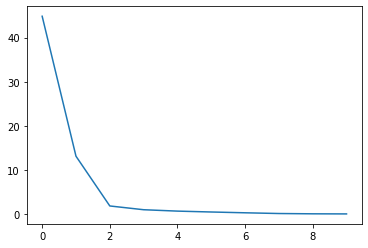

In [49]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

#### 预测

下面的代码用训练的RNN模型从某个时刻的数据预测后面500个时刻的输出：

In [ ]:
H = rnn_hidden_state_init(1,hidden_size)   

start = 3
x = data[start:start+1].copy()
x =x.reshape(x.shape[0],1,-1)
print(x.shape)
x = x.reshape(1,-1)
ys =[]
print(x.flatten())
for i in range(500):
    F,H= rnn_forward_step(params,x,H) 
    x=F
    ys.append(F[0,0])    
    
print(len(ys))   
ys  = ys[:]
plt.plot(ys[:500])
plt.plot(data[start+1:start+1+500])
plt.xlabel("time")
plt.ylabel("value")
plt.legend(['y','y_real'])
plt.show()

这个预测不是很准确，如果只从当前时刻预测其下一时刻的数据，即从`data[t]`预测`data[t+1]`。下面的代码采用这种短期预测方式从`data[start,start+500]`中的每个时刻的数据取预测下一时刻的数据，即预测`data[start+1,start+1+500]`

In [ ]:
H = rnn_hidden_state_init(1,hidden_size)   

start = 3
ys =[]
for i in range(500):
    x= data[start+i:start+i+1].copy()
    x = x.reshape(1,-1)
    F,H= rnn_forward_step(params,x,H)
    ys.append(F[0,0])
 
    
ys  = ys[:]
plt.plot(ys[:500])
plt.plot(data[start+1:start+501])
plt.xlabel("time")
plt.ylabel("value")
plt.legend(['y','y_real'])
plt.show()

短期预测下一时刻的结果和真实数据完全重合，说明短期预测很好。 上述RNN的相关代码在本书代码的`rnn.py`文件中。

#### 股票数据的训练和预测

对于股票数据，可以只用股票的收盘价作为序列数据进行股票收盘价的预测，下面代码将股票的收盘价数据作为自回归数据：

In [51]:
data = read_stock('sp500.csv')
data = np.array(data.iloc[:,-2]).reshape(-1,1)

下面代码用股票的所有指标（开盘价、最高价、最低价、收盘价、交易量）对股票收盘价进行预测，首先同样训练RNN模型：

stock_data.shape (4697, 5)
stock_data[:3]
 [[-0.00597324 -0.00591629 -0.01567558 -0.01231037 -0.19118446]
 [-0.01226569 -0.01617188 -0.03401657 -0.03724877 -0.1842296 ]
 [-0.0372919  -0.03505779 -0.04286668 -0.03604657 -0.17733781]]
(100, 1, 5) (100, 1)
iter 0, loss: 0.104486
iter 200, loss: 0.091125
iter 400, loss: 0.554865
iter 600, loss: 0.058518
iter 800, loss: 0.410151
iter 1000, loss: 2.299701
iter 1200, loss: 0.474510
iter 1400, loss: 0.009689
iter 1600, loss: 0.005832
iter 1800, loss: 0.011212
iter 2000, loss: 0.032087
iter 0, loss: 0.015169
iter 200, loss: 0.003068
iter 400, loss: 0.003498
iter 600, loss: 0.010243
iter 800, loss: 0.003282
iter 1000, loss: 0.002962
iter 1200, loss: 0.006242
iter 1400, loss: 0.009083
iter 1600, loss: 0.002326
iter 1800, loss: 0.010486
iter 2000, loss: 0.026038


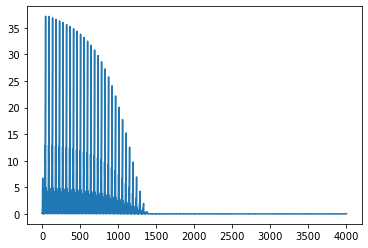

In [52]:
import pandas as pd
import numpy as np

data = read_stock('sp500.csv')

stock_data = np.array(data)
print("stock_data.shape",stock_data.shape)
print("stock_data[:3]\n",stock_data[:3])

def stock_data_iter(data,seq_length):
    feature_n = data.shape[1]
    num = (len(data)-1)//seq_length    
    while True:       
        for i in range(num):
            #选取一个训练样本 
            p = i*seq_length
            inputs = data[p:p+seq_length]
            targets = data[p+1:p+seq_length+1][:,-2]  
            inputs = np.expand_dims(inputs, axis=1)
            targets  = targets.reshape(-1,1)
            if i==0:
                yield inputs,targets,True
            else: 
                yield inputs,targets,False


batch_size = 1 
input_dim= stock_data.shape[1]
hidden_dim = 100
output_dim=1
params = rnn_params_init(input_dim, hidden_dim,output_dim)
H = rnn_hidden_state_init(batch_size,hidden_dim)

seq_length = 100 # number of steps to unroll the RNN for

data_it = stock_data_iter(stock_data, seq_length)
X,Y,_ = next(data_it)
print(X.shape,Y.shape)

loss_function = lambda F,Y:rnn_loss_grad(F,Y,util.mse_loss_grad,False)

# hyperparameters
epoches = 2
learning_rate = 1e-4
iterations  =2000
losses = []

#optimizer = AdaGrad(params,learning_rate)
momentum = 0.9
optimizer = SGD(params,learning_rate,momentum)

for epoch in range(epoches):
    data_it =  stock_data_iter(stock_data, seq_length)
   # epoch_losses,param,H = rnn_train(params,data_it,learning_rate,iterations,loss_function,print_n=100)
    epoch_losses,H = rnn_train_epoch(params,data_it,optimizer,iterations,loss_function,print_n=200)
    losses.extend(epoch_losses)  
    #epoch_losses = np.array(epoch_losses).mean()   
    #losses.append(epoch_losses)  
plt.plot(losses)

上述的序列数据不是自回归数据，每个时刻股票数据是多个特征构成的向量，而预测的下一时刻的股票价格是一个数值，即输入是多个值的向量而输出是一个值的数据，根据该模型无法进行长期预测。下面代码是根据训练的RNN进行的短期预测：

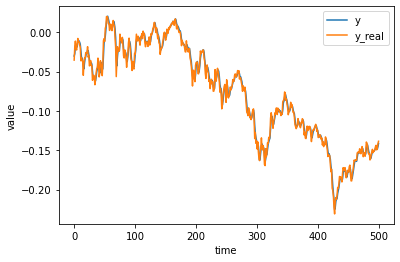

In [53]:
H = rnn_hidden_state_init(1,hidden_dim)   

start = 3
data = stock_data[start:,:]

ys =[]
for i in range(len(data)):
    x= data[i,:].copy()
    x = x.reshape(1,-1)
    f,H = rnn_forward_step(params,x,H)     
    ys.append(f[0,0])

ys  = ys[:]
plt.plot(ys[:500])
plt.plot(data[:500,-2])
plt.xlabel("time")
plt.ylabel("value")
plt.legend(['y','y_real'])
plt.show()

## 7.5 RNN语言模型和文本生成
### 7.5.1 字符表

In [54]:
filename = 'input.txt'
data = open(filename, 'r').read()
chars = list(set(data))

输出文本中所有字符的数目和字符表的长度，字符表前10个字符和文本的前148个字符：

In [55]:
data_size, vocab_size = len(data), len(chars)
print ('总字符个数 %d,字符表的长度 %d unique.' % (data_size, vocab_size))
print('字符表的前10个字符：\n',chars[:10])
print('前148个字符：\n',data[:148])

总字符个数 1115394,字符表的长度 65 unique.
字符表的前10个字符：
 ['R', ':', 'B', 'k', ' ', '$', 'X', 'b', 'M', 'H']
前148个字符：
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



字符表中的每个字符对应一个下标，可以用2个字典表示字符到下标、下标到字符的映射关系：

In [56]:
char_to_idx = { ch:i for i,ch in enumerate(chars) }
idx_to_char = { i:ch for i,ch in enumerate(chars) }

函数one_hot_idx根据字符（单词）表大小vocab_size和一个字符在字符（单词）表的下标idx将该字符转化为一个one-hot向量：

In [57]:
def one_hot_idx(idx,vocab_size):  
    x = np.zeros((1,vocab_size)) 
    x[0,idx] = 1  
    return x

### 7.5.2  字符序列样本的采样

下面代码是采用顺序采样方式采样字符序列样本：

In [58]:
import numpy as np
def character_seq_data_iter_consecutive(data, batch_size, seq_len,start_range=10):
      #每次在data[offset:]里采样，使得每一个epoch的训练样本不同
    start = np.random.randint(0, start_range)     
    block_len = (len(data)-start-1) // batch_size
    num_batches = block_len // seq_len  #每块里最多能连续采样的批数
    bs = np.array(range(0,block_len*batch_size,block_len) ) #每个block起始位置
    
    i_end = num_batches * seq_len
    for i in range(0, i_end, seq_len): #一个block的序列开始位置
        s = start+i              #在一个block里的位置
        X = np.empty((seq_len,batch_size),dtype=object)#,dtype = np.int32)
        Y = np.empty((seq_len,batch_size),dtype=object)#,dtype = np.int32) 
        for b in range(batch_size): #b表示一个批样本的第几个样本
            s_b = s+bs[b]
            for t in range(seq_len):
                X[t,b] = data[s_b]
                Y[t,b] = data[s_b+1]
                s_b +=1 
        if i==0:
            yield X,Y,True
        else:
            yield X,Y,False

测试一下这个函数：

In [59]:
x = 'Li,where are you from'
batch_size = 2
seq_length  = 3
data_it = character_seq_data_iter_consecutive(x,batch_size,seq_length,1)

i = 0 
for x,y,_ in data_it:
    print("x:",x)
    print("y",y)
    i+=1
    if i==2:break

x: [['L' 'r']
 ['i' 'e']
 [',' ' ']]
y [['i' 'e']
 [',' ' ']
 ['w' 'y']]
x: [['w' 'y']
 ['h' 'o']
 ['e' 'u']]
y [['h' 'o']
 ['e' 'u']
 ['r' ' ']]


函数返回的字符需要进一步将它们向量化，如将每个字符转化为one-hot向量形式，为此，修改上述的函数：

In [60]:
def character_seq_data_iter_consecutive(data, batch_size, seq_len,vocab_size,start_range=10):
      #每次在data[offset:]里采样，使得每一个epoch的训练样本不同
    start = np.random.randint(0, start_range)     
    block_len = (len(data)-start-1) // batch_size
    num_batches = block_len // seq_len  #每块里最多能连续采样的批数
    bs = np.array(range(0,block_len*batch_size,block_len) )

    i_end = num_batches * seq_len
    for i in range(0, i_end, seq_len):
        s = start+i
        X = np.empty((seq_len,batch_size,vocab_size),dtype = np.int32)
        Y = np.empty((seq_len,batch_size,1),dtype = np.int32) 
        for b in range(batch_size):
            s_b = s+bs[b]
            for t in range(seq_len):
                X[t,b,:] = one_hot_idx(char_to_idx[data[s_b]],vocab_size)
                Y[t,b,:] = char_to_idx[data[s_b+1]]
                s_b +=1 
        if i==0:
            yield X,Y,True
        else:
            yield X,Y,False

同样，测试一下这个函数：

In [61]:
x = 'Li,where are you from'
batch_size = 2
seq_length  = 3
data_it = character_seq_data_iter_consecutive(x,batch_size,seq_length,vocab_size,1)
i = 0 
for x,y,_ in data_it:
    print("x:",x)
    print("y",y)
    i+=1
    if i==2:break

x: [[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]]
y [[[28]
  [29]]

 [[25]
  [ 4]]

 [[10]
  [45]]]
x: [[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### 7.5.3 RNN模型的训练和预测

初始化一个RNN模型

In [62]:
batch_size = 1
input_dim = vocab_size
output_dim= vocab_size
hidden_size=100
params = rnn_params_init(input_dim, hidden_size,output_dim)
H = rnn_hidden_state_init(batch_size,hidden_size)

#### 预测

根据输出字符序列prefix生成其后面的一系列字符

In [63]:
def predict_rnn(params,prefix,n): 
    Wx, Wh,bh, Wf,bf =  params
    #Wxh, Whh,Why, bh, by =params["Wxh"],params["Whh"],params["Why"],params["bh"],params["by"]
    vocab_size,hidden_size = Wx.shape[0],Wh.shape[1]
    h = rnn_hidden_state_init(1,hidden_size) 
    
    output = [char_to_idx[prefix[0]]]
   
    for t in range(len(prefix) +n - 1):        
        # 将上⼀时间步的输出作为当前时间步的输⼊。
        x = one_hot_idx(output[-1], vocab_size)
        
        z,h = rnn_forward_step(params,x,h) 
        
        #h = np.tanh(np.dot(x,Wx) + np.dot(h,Wh) + bh)
        #z = np.dot(h,Wf) + bf   
           
        
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            p = np.exp(z) / np.sum(np.exp(z)) 
           # idx = int(p.argmax(axis=1))
            idx = np.random.choice(range(vocab_size), p=p.ravel())
            output.append(idx)
     
        
    return ''.join([idx_to_char[i] for i in output])

测试这个预测函数：

In [64]:
str = predict_rnn(params,"he",200)
print(str)

heUBxdCs$CUhNEbamqryTQwoTrjaUf?bQrPwavKEmKW?&PLC;y3rxtRsfZ,Aw!ZN uSi,dAMAHiuL'REBvIDtHSfHoqe?iY oT$otSKMauIWu:pvDTybogwULnaXSt;zcCb3RmicebCO'glm'yMebVwwH!$ACyS'!S,-EGftqKY?a!I!JUcf,$EHfebGAboL,X;hRwD'W&


由于初始的RNN模型参数是随机的，预测也是随机的.

可以用一个文本语料库采样的序列样本去训练RNN模型，如下面的代码：

iter 0, loss: 104.361004
iter 10, loss: 97.472131
iter 20, loss: 86.091293
iter 30, loss: 79.406612
iter 40, loss: 88.922930
iter 50, loss: 79.985450
iter 60, loss: 71.960680
iter 70, loss: 76.690542
iter 80, loss: 84.517184
iter 90, loss: 71.955153
iter 100, loss: 75.725653
iter 110, loss: 69.368085
iter 120, loss: 62.038989
iter 130, loss: 74.409354
iter 140, loss: 66.337256
iter 150, loss: 68.378187
iter 160, loss: 85.795793
iter 170, loss: 60.102835
iter 180, loss: 69.481062
iter 190, loss: 69.190731
iter 200, loss: 63.577186
iter 210, loss: 65.356981
iter 220, loss: 72.267375
iter 230, loss: 58.723288
iter 240, loss: 68.140474
iter 250, loss: 67.969647
iter 260, loss: 66.508415
iter 270, loss: 63.041488
iter 280, loss: 63.933792
iter 290, loss: 70.054530
iter 300, loss: 61.832320
iter 310, loss: 68.717617
iter 320, loss: 63.294286
iter 330, loss: 58.036336
iter 340, loss: 59.408535
iter 350, loss: 62.804017
iter 360, loss: 65.766444
iter 370, loss: 60.278396
iter 380, loss: 69.232

iter 3090, loss: 59.251406
iter 3100, loss: 56.509121
iter 3110, loss: 62.082168
iter 3120, loss: 49.662347
iter 3130, loss: 56.029247
iter 3140, loss: 60.479339
iter 3150, loss: 52.494697
iter 3160, loss: 44.704861
iter 3170, loss: 50.448692
iter 3180, loss: 56.273608
iter 3190, loss: 53.337867
iter 3200, loss: 53.760471
iter 3210, loss: 59.267055
iter 3220, loss: 53.883394
iter 3230, loss: 58.752546
iter 3240, loss: 59.835015
iter 3250, loss: 51.046193
iter 3260, loss: 54.236519
iter 3270, loss: 58.974334
iter 3280, loss: 49.927336
iter 3290, loss: 63.624387
iter 3300, loss: 58.777622
iter 3310, loss: 52.589049
iter 3320, loss: 54.873365
iter 3330, loss: 53.759251
iter 3340, loss: 59.860628
iter 3350, loss: 52.153970
iter 3360, loss: 58.365416
iter 3370, loss: 48.000195
iter 3380, loss: 53.871132
iter 3390, loss: 57.505869
iter 3400, loss: 47.136835
iter 3410, loss: 65.079016
iter 3420, loss: 58.874432
iter 3430, loss: 58.992275
iter 3440, loss: 46.657104
iter 3450, loss: 50.654499
i

iter 6150, loss: 52.285108
iter 6160, loss: 53.616702
iter 6170, loss: 52.597303
iter 6180, loss: 51.604783
iter 6190, loss: 57.644969
iter 6200, loss: 45.231109
iter 6210, loss: 53.265419
iter 6220, loss: 43.726855
iter 6230, loss: 47.115828
iter 6240, loss: 55.299831
iter 6250, loss: 50.022167
iter 6260, loss: 59.505827
iter 6270, loss: 54.534978
iter 6280, loss: 49.088351
iter 6290, loss: 48.185761
iter 6300, loss: 42.480974
iter 6310, loss: 48.772047
iter 6320, loss: 58.643551
iter 6330, loss: 54.769705
iter 6340, loss: 64.125759
iter 6350, loss: 48.244387
iter 6360, loss: 42.883836
iter 6370, loss: 51.007663
iter 6380, loss: 46.078514
iter 6390, loss: 52.477564
iter 6400, loss: 52.652588
iter 6410, loss: 48.125238
iter 6420, loss: 48.451619
iter 6430, loss: 42.967870
iter 6440, loss: 51.290346
iter 6450, loss: 56.536736
iter 6460, loss: 53.439852
iter 6470, loss: 53.288620
iter 6480, loss: 55.158005
iter 6490, loss: 50.673808
iter 6500, loss: 50.062880
iter 6510, loss: 49.440131
i

iter 9200, loss: 56.275797
iter 9210, loss: 58.891180
iter 9220, loss: 50.529215
iter 9230, loss: 47.656521
iter 9240, loss: 53.505391
iter 9250, loss: 48.021675
iter 9260, loss: 45.756631
iter 9270, loss: 42.406196
iter 9280, loss: 45.402726
iter 9290, loss: 50.828804
iter 9300, loss: 44.839874
iter 9310, loss: 52.258535
iter 9320, loss: 50.494717
iter 9330, loss: 52.945707
iter 9340, loss: 57.266904
iter 9350, loss: 47.936718
iter 9360, loss: 56.191069
iter 9370, loss: 49.944280
iter 9380, loss: 47.020589
iter 9390, loss: 47.476995
iter 9400, loss: 58.207060
iter 9410, loss: 56.300600
iter 9420, loss: 42.170880
iter 9430, loss: 47.390354
iter 9440, loss: 49.276764
iter 9450, loss: 58.455474
iter 9460, loss: 52.535674
iter 9470, loss: 43.373046
iter 9480, loss: 50.375354
iter 9490, loss: 51.643642
iter 9500, loss: 48.902864
iter 9510, loss: 49.231702
iter 9520, loss: 50.173678
iter 9530, loss: 51.806335
iter 9540, loss: 48.787198
iter 9550, loss: 59.461751
iter 9560, loss: 46.548160
i

iter 2280, loss: 59.216991
iter 2290, loss: 44.673790
iter 2300, loss: 51.791257
iter 2310, loss: 43.675328
iter 2320, loss: 38.386960
iter 2330, loss: 46.261426
iter 2340, loss: 47.174309
iter 2350, loss: 41.220402
iter 2360, loss: 47.379241
iter 2370, loss: 50.044227
iter 2380, loss: 48.540619
iter 2390, loss: 50.824249
iter 2400, loss: 45.132628
iter 2410, loss: 48.837710
iter 2420, loss: 46.102138
iter 2430, loss: 43.411012
iter 2440, loss: 58.791724
iter 2450, loss: 50.669030
iter 2460, loss: 52.600115
iter 2470, loss: 46.394589
iter 2480, loss: 46.817879
iter 2490, loss: 48.043023
iter 2500, loss: 46.697672
iter 2510, loss: 45.603154
iter 2520, loss: 47.595132
iter 2530, loss: 44.005118
iter 2540, loss: 51.508966
iter 2550, loss: 45.220814
iter 2560, loss: 48.946412
iter 2570, loss: 59.546550
iter 2580, loss: 51.723267
iter 2590, loss: 56.619288
iter 2600, loss: 48.790185
iter 2610, loss: 48.737237
iter 2620, loss: 54.929357
iter 2630, loss: 53.436869
iter 2640, loss: 49.705118
i

iter 5350, loss: 47.553023
iter 5360, loss: 37.332645
iter 5370, loss: 51.112696
iter 5380, loss: 39.976442
iter 5390, loss: 54.025113
iter 5400, loss: 49.064420
iter 5410, loss: 53.620668
iter 5420, loss: 49.821853
iter 5430, loss: 45.579129
iter 5440, loss: 45.761417
iter 5450, loss: 55.441843
iter 5460, loss: 44.606284
iter 5470, loss: 54.606057
iter 5480, loss: 47.585725
iter 5490, loss: 41.118512
iter 5500, loss: 52.730339
iter 5510, loss: 41.902090
iter 5520, loss: 53.282205
iter 5530, loss: 48.912842
iter 5540, loss: 49.495038
iter 5550, loss: 50.157429
iter 5560, loss: 46.921494
iter 5570, loss: 44.856232
iter 5580, loss: 63.535679
iter 5590, loss: 53.633174
iter 5600, loss: 46.570373
iter 5610, loss: 56.899129
iter 5620, loss: 47.681893
iter 5630, loss: 55.090615
iter 5640, loss: 46.863456
iter 5650, loss: 52.805774
iter 5660, loss: 51.651305
iter 5670, loss: 47.744157
iter 5680, loss: 35.402861
iter 5690, loss: 39.017570
iter 5700, loss: 52.453397
iter 5710, loss: 51.187443
i

iter 8410, loss: 45.226566
iter 8420, loss: 45.310348
iter 8430, loss: 55.960603
iter 8440, loss: 41.513407
iter 8450, loss: 46.746003
iter 8460, loss: 49.254285
iter 8470, loss: 39.925867
iter 8480, loss: 49.714026
iter 8490, loss: 47.654167
iter 8500, loss: 37.280492
iter 8510, loss: 47.976060
iter 8520, loss: 42.160926
iter 8530, loss: 47.757451
iter 8540, loss: 41.787425
iter 8550, loss: 38.472854
iter 8560, loss: 50.320390
iter 8570, loss: 49.229887
iter 8580, loss: 50.002153
iter 8590, loss: 43.356254
iter 8600, loss: 53.147437
iter 8610, loss: 48.726022
iter 8620, loss: 46.645736
iter 8630, loss: 43.750331
iter 8640, loss: 56.350650
iter 8650, loss: 38.156051
iter 8660, loss: 50.338374
iter 8670, loss: 46.199894
iter 8680, loss: 52.830486
iter 8690, loss: 42.372412
iter 8700, loss: 42.039606
iter 8710, loss: 52.676715
iter 8720, loss: 45.180604
iter 8730, loss: 40.903198
iter 8740, loss: 56.111697
iter 8750, loss: 40.708679
iter 8760, loss: 46.084195
iter 8770, loss: 44.715694
i

iter 1480, loss: 45.958934
iter 1490, loss: 44.516124
iter 1500, loss: 51.738455
iter 1510, loss: 37.058443
iter 1520, loss: 34.351946
iter 1530, loss: 52.491599
iter 1540, loss: 56.976123
iter 1550, loss: 52.360322
iter 1560, loss: 48.086297
iter 1570, loss: 44.623658
iter 1580, loss: 50.007954
iter 1590, loss: 48.924502
iter 1600, loss: 40.030286
iter 1610, loss: 60.642858
iter 1620, loss: 42.263072
iter 1630, loss: 51.501963
iter 1640, loss: 51.211773
iter 1650, loss: 42.469517
iter 1660, loss: 49.055865
iter 1670, loss: 49.137801
iter 1680, loss: 59.841450
iter 1690, loss: 48.303087
iter 1700, loss: 50.690881
iter 1710, loss: 51.695362
iter 1720, loss: 48.817172
iter 1730, loss: 48.793154
iter 1740, loss: 49.299206
iter 1750, loss: 53.730209
iter 1760, loss: 47.242494
iter 1770, loss: 57.793441
iter 1780, loss: 50.646628
iter 1790, loss: 47.219776
iter 1800, loss: 45.555321
iter 1810, loss: 42.729135
iter 1820, loss: 45.388676
iter 1830, loss: 55.800073
iter 1840, loss: 50.674537
i

iter 4520, loss: 54.563423
iter 4530, loss: 41.597372
iter 4540, loss: 44.913788
iter 4550, loss: 51.417144
iter 4560, loss: 52.855950
iter 4570, loss: 39.877595
iter 4580, loss: 46.452591
iter 4590, loss: 51.976659
iter 4600, loss: 51.891283
iter 4610, loss: 53.132678
iter 4620, loss: 48.756029
iter 4630, loss: 48.257117
iter 4640, loss: 53.580630
iter 4650, loss: 52.175435
iter 4660, loss: 45.768131
iter 4670, loss: 54.437266
iter 4680, loss: 54.749657
iter 4690, loss: 47.380986
iter 4700, loss: 50.571072
iter 4710, loss: 49.443375
iter 4720, loss: 45.249754
iter 4730, loss: 42.799695
iter 4740, loss: 47.714544
iter 4750, loss: 45.487326
iter 4760, loss: 41.969927
iter 4770, loss: 46.914511
iter 4780, loss: 61.627957
iter 4790, loss: 50.913301
iter 4800, loss: 50.638062
iter 4810, loss: 44.077344
iter 4820, loss: 41.383226
iter 4830, loss: 38.566634
iter 4840, loss: 48.168571
iter 4850, loss: 39.737978
iter 4860, loss: 45.220567
iter 4870, loss: 50.103693
iter 4880, loss: 39.413614
i

iter 7580, loss: 52.245992
iter 7590, loss: 39.682072
iter 7600, loss: 42.125573
iter 7610, loss: 47.469673
iter 7620, loss: 45.716486
iter 7630, loss: 41.355220
iter 7640, loss: 57.242924
iter 7650, loss: 43.180213
iter 7660, loss: 42.627850
iter 7670, loss: 52.239464
iter 7680, loss: 38.959283
iter 7690, loss: 46.848278
iter 7700, loss: 40.909716
iter 7710, loss: 54.717638
iter 7720, loss: 46.218922
iter 7730, loss: 52.094211
iter 7740, loss: 41.096205
iter 7750, loss: 50.325478
iter 7760, loss: 35.710337
iter 7770, loss: 38.092494
iter 7780, loss: 51.301988
iter 7790, loss: 44.439617
iter 7800, loss: 41.667749
iter 7810, loss: 41.366712
iter 7820, loss: 41.516491
iter 7830, loss: 53.071316
iter 7840, loss: 50.265368
iter 7850, loss: 37.986791
iter 7860, loss: 33.623053
iter 7870, loss: 43.757147
iter 7880, loss: 44.639271
iter 7890, loss: 60.472348
iter 7900, loss: 40.617018
iter 7910, loss: 43.047286
iter 7920, loss: 49.546051
iter 7930, loss: 45.419311
iter 7940, loss: 45.370908
i

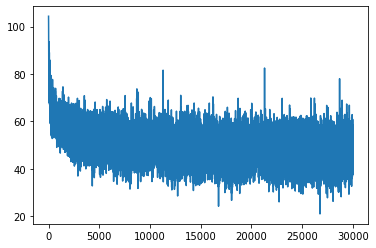

In [65]:
import matplotlib.pyplot as plt

batch_size = 3
input_dim = vocab_size
output_dim= vocab_size
hidden_size=100
params = rnn_params_init(input_dim, hidden_size,output_dim)
H = rnn_hidden_state_init(batch_size,hidden_size)
seq_length = 25

loss_function = lambda F,Y:rnn_loss_grad(F,Y) #,util.loss_grad_least)


epoches = 3
learning_rate = 1e-2
iterations  =10000
losses = []

optimizer = AdaGrad(params,learning_rate)
momentum = 0.9
optimizer = SGD(params,learning_rate,momentum)

for epoch in range(epoches):
    data_it =  character_seq_data_iter_consecutive(data,batch_size,seq_length,vocab_size,100)
   # epoch_losses,param,H = rnn_train(params,data_it,learning_rate,iterations,loss_function,print_n=100)
    epoch_losses,H = rnn_train_epoch(params,data_it,optimizer,iterations,loss_function,print_n=10)
    losses.extend(epoch_losses)  
    #epoch_losses = np.array(epoch_losses).mean()   
    #losses.append(epoch_losses)  
plt.plot(losses[:])

用训练后的RNN再次进行预测：

In [66]:
str = predict_rnn(params,"he",200)
print(str)

hew frighs; of dit moow Frilider: well or thing adsor;
Youncizedarrio, 
Clock, werns I'lm'd ever in dep.
Koth swend,
Cite?
I deyorse enioth Low, you.

HED ALA:
Afe cond his comine, well bromariasane, Su


### 7.7.3  LSTM的代码实现

初始化这些模型参数

In [67]:
import numpy as np
def lstm_params_init(input_dim,hidden_dim,output_dim,scale=0.01):
    normal = lambda m,n : np.random.randn(m, n)*scale
    two = lambda : (normal(input_dim+hidden_dim, hidden_dim),np.zeros((1,hidden_dim)))
    
    Wi, bi = two()  # Input gate parameters
    Wf, bf = two()  # Forget gate parameters
    Wo, bo = two()  # Output gate parameters
    Wc, bc = two()  # Candidate cell parameters
    
    Wy = normal(hidden_dim, output_dim)
    by = np.zeros((1,output_dim))
   
    params = [Wi, bi,Wf, bf, Wo,bo, Wc,bc,Wy,by]
    return params

初始化元胞状态$C_t$和隐状态$h_t$：

In [68]:
def lstm_state_init(batch_size, hidden_size):
    return (np.zeros((batch_size, hidden_size)),
            np.zeros((batch_size, hidden_size)))

正向计算（前向传播）：

In [69]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lstm_forward(params,Xs, state):
    [Wi, bi,Wf, bf, Wo,bo,Wc,bc,Wy,by] = params   
    
    (H, C) = state         #初始状态
    Hs = {}
    Cs = {}
    Zs = []
    
    Hs[-1] = np.copy(H)
    Cs[-1] = np.copy(C)
    
    Is = []
    Fs = []
    Os = []
    C_tildas = []
    
    for t in range(len(Xs)): 
        X = Xs[t]
        XH = np.column_stack((X, H))
        if False:
            print("XH.shape",XH.shape)
            print("Wi.shape",Wi.shape)
            break
        I = sigmoid(np.dot(XH, Wi)+bi)
        F = sigmoid(np.dot(XH, Wf)+bf)
        O = sigmoid(np.dot(XH, Wo)+bo)
        C_tilda = np.tanh(np.dot(XH, Wc)+bc)
    
        C = F * C + I * C_tilda
        H = O*np.tanh(C)       #O * C.tanh()  #输出状态 
        
        Y = np.dot(H, Wy) + by        # 输出
        
        Zs.append(Y)
        Hs[t] = H
        Cs[t] = C
        
        Is.append(I)
        Fs.append(F)
        Os.append(O)
        C_tildas.append(C_tilda)
    return Zs,Hs,Cs,(Is,Fs,Os,C_tildas)

同样，也可以将其中某个时刻的正向计算单独作为一个函数：

In [ ]:
def lstm_forward_step(params,X,H,C):
    [Wi, bi,Wf, bf, Wo,bo,Wc,bc,Wy,by] = params
    
    XH = np.column_stack((X, H))
    I = sigmoid(np.dot(XH, Wi)+bi)
    F = sigmoid(np.dot(XH, Wf)+bf)
    O = sigmoid(np.dot(XH, Wo)+bo)
    C_tilda = np.tanh(np.dot(XH, Wc)+bc)
    
    C = F * C + I * C_tilda
    H = O*np.tanh(C)       #O * tanh(C)  #输出状态 
    Y = np.dot(H, Wy) + by        # 输出
    
    return Y,H,C,(I,F,O,C_tilda)

反向求导：

In [ ]:
import math

def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def dtanh(x):
    return 1 - np.tanh(x) * np.tanh(x)

def grad_clipping(grads,alpha):
    norm = math.sqrt(sum((grad ** 2).sum() for grad in grads))
    if norm > alpha:
        ratio = alpha / norm
        for i in range(len(grads)):
            grads[i]*=ratio 
            
def lstm_backward(params,Xs,Hs,Cs,dZs,cache,clip_value = 5.): # Ys,loss_function):
    [Wi, bi,Wf, bf, Wo,bo,Wc, bc,Wy,by] = params
    
    Is,Fs,Os,C_tildas = cache    
    
    dWi,dWf,dWo,dWc,dWy  = np.zeros_like(Wi), np.zeros_like(Wf), np.zeros_like(Wo), np.zeros_like(Wc), np.zeros_like(Wy)
    dbi,dbf,dbo,dbc,dby = np.zeros_like(bi), np.zeros_like(bf),  np.zeros_like(bo), np.zeros_like(bc), np.zeros_like(by)

    dH_next = np.zeros_like(Hs[0])
    dC_next = np.zeros_like(Cs[0])
    
    input_dim = Xs[0].shape[1]
  
    h = Hs
    x = Xs
    
    T = len(Xs)  
    for t in reversed(range(T)):     
        I = Is[t]
        F = Fs[t]
        O = Os[t]
        C_tilda = C_tildas[t]
        H = Hs[t]
        X = Xs[t]
        C = Cs[t]
        H_pre =  Hs[t-1]
        C_prev = Cs[t-1]
        XH_pre = np.column_stack((X, H_pre))
        XH_ = XH_pre
        
        dZ = dZs[t]  
    
        #输出f的模型参数的idu
        dWy += np.dot(H.T,dZ)      
        dby += np.sum(dZ, axis=0, keepdims=True)   
        
        #隐状态h的梯度
        dH = np.dot(dZ, Wy.T) + dH_next      
     
        dC = dH*O*dtanh(C) +dC_next  # H_t= O_t*tanh(C_t)
        
        dO = np.tanh(C) *dH     
        dOZ = O * (1-O)*dO          #O = sigma(Z_o)            
        dWo += np.dot(XH_.T,dOZ)    # Z_o = (X,H_)W_o+b_o
        dbo += np.sum(dOZ, axis=0, keepdims=True)              
        
         #di                         
        di =  C_tilda*dC
        diZ = I*(1-I) * di
        dWi += np.dot(XH_.T,diZ)
        dbi += np.sum(diZ, axis=0, keepdims=True)  
        
        #df
        df = C_prev*dC
        dfZ = F*(1-F) * df
        dWf += np.dot(XH_.T,dfZ)
        dbf += np.sum(dfZ, axis=0, keepdims=True)          
        
        # dC_bar       
        dC_tilda = I*dC                         #C = F * C + I * C_tilda        
        dC_tilda_Z =(1-np.square(C_tilda))*dC_tilda    # C_tilda = tanh(C_tilda_Z)         
        dWc += np.dot(XH_.T,dC_tilda_Z)     # C_tilda_Z = (X,H_)W_c+b_c    
        dbc += np.sum(dC_tilda_Z, axis=0, keepdims=True)
       
        dXH_ = (np.dot(dfZ, Wf.T)
             + np.dot(diZ, Wi.T)
             + np.dot(dC_tilda_Z, Wc.T)
             + np.dot(dOZ, Wo.T))
    
        dX_prev = dXH_[:, :input_dim]
        dH_prev = dXH_[:, input_dim:]
        dC_prev = F * dC
        
        dC_next = dC_prev
        dH_next = dH_prev      

    grads = [dWi, dbi,dWf, dbf, dWo,dbo,dWc, dbc,dWy,dby]
    grad_clipping(grads,clip_value)
    #for dparam in [dWi, dbi,dWf, dbf, dWo,dbo,dWc, dbc,dWy,dby]:
    #    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return grads

梯度检验

In [ ]:
T  = 3
input_dim, hidden_dim,output_dim = 4,3,4
batch_size = 2        
Xs = np.random.randn(T,batch_size,input_dim)
Ys = np.random.randint(output_dim, size=(T,batch_size))
 
print("Xs",Xs)
print("Ys",Ys)        
        
# cheack gradient  
params = lstm_params_init(input_dim, hidden_dim,output_dim)
HC = lstm_state_init(batch_size,hidden_dim)

Zs,Hs,Cs,cache = lstm_forward(params,Xs,HC) 
loss_function = rnn_loss_grad
loss,dZs = loss_function(Zs,Ys)  

grads = lstm_backward(params,Xs,Hs,Cs,dZs,cache)

def rnn_loss():
    HC = lstm_state_init(batch_size,hidden_dim)    
    Zs,Hs,Cs,cache= lstm_forward(params,Xs,HC) 
    loss_function = rnn_loss_grad
    loss,dZs = loss_function(Zs,Ys)     
    return loss

numerical_grads = util.numerical_gradient(rnn_loss,params,1e-6) #rnn_numerical_gradient(rnn_loss,params,1e-10)
#diff_error = lambda x, y: np.max( np.abs(x - y)/(np.maximum(1e-8, np.abs(x) + np.abs(y))))
diff_error = lambda x, y: np.max( np.abs(x - y))
                                 
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

print("loss",loss)
print("[Wi, bi,Wf, bf, Wo,bo,Wc, bc,Wy,by] ")
for i in range(len(grads)):
    print(diff_error(grads[i],numerical_grads[i]))

print("grads",grads[0])
print("numerical_grads",numerical_grads[0])

同样，可以定义梯度下降法的一次迭代过程：

In [ ]:
def lstm_train_epoch(params,data_iter,optimizer,iterations,loss_function,print_n=100):
    Wi, bi,Wf, bf, Wo,bo,Wc, bc,Wy,by = params
    #Wxh, Whh,Why, bh, by =params["Wxh"],params["Whh"],params["Why"],params["bh"],params["by"]
    losses = []      
    iter = 0
    
    batch_size = None
    hidden_size = Wy.shape[0]
   
    for Xs,Ys,start in data_iter:
        if not batch_size:
            batch_size = Xs[0].shape[0]            
        if start:
            HC = lstm_state_init(batch_size,hidden_size) 
        
        Zs,Hs,Cs,cache = lstm_forward(params,Xs,HC) 
        loss,dZs = loss_function(Zs,Ys)  
        grads = lstm_backward(params,Xs,Hs,Cs,dZs,cache)
      
        optimizer.step(grads)
        losses.append(loss)
        
        if iter % print_n == 0: 
            print ('iter %d, loss: %f' % (iter, loss)) 
        iter+=1
        
        if iter>iterations:break
    return losses,H

文本生成

In [ ]:
filename = 'input.txt'
data = open(filename, 'r').read()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('总字符个数 %d,字符表的长度 %d unique.' % (data_size, vocab_size))

char_to_idx = { ch:i for i,ch in enumerate(chars) }
idx_to_char = { i:ch for i,ch in enumerate(chars) }

input_dim, hidden_dim,output_dim = vocab_size,100,vocab_size
batch_size = 2   

params = lstm_params_init(input_dim, hidden_dim,output_dim)
H = lstm_state_init(batch_size,hidden_dim)
seq_length = 25

loss_function = lambda F,Y:rnn_loss_grad(F,Y) #,util.loss_grad_least)

epoches = 3
learning_rate = 1e-2
iterations  =10000
losses = []

optimizer = AdaGrad(params,learning_rate)
momentum = 0.9
optimizer = SGD(params,learning_rate,momentum)

for epoch in range(epoches):
    data_it =  character_seq_data_iter_consecutive(data,batch_size,seq_length,vocab_size,100)
   # epoch_losses,param,H = rnn_train(params,data_it,learning_rate,iterations,loss_function,print_n=100)
    epoch_losses,H = lstm_train_epoch(params,data_it,optimizer,iterations,loss_function,print_n=10)
    losses.extend(epoch_losses)  
    #epoch_losses = np.array(epoch_losses).mean()   
    #losses.append(epoch_losses)

#### 预测

和rnn类似，可以定义如下的预测函数：

In [ ]:
def predict_lstm(params,prefix,n): 
    Wi, bi,Wf, bf, Wo,bo,Wc, bc,Wy,by = params
    vocab_size,hidden_dim = Wi.shape[0]-Wy.shape[0],Wy.shape[0]
    h,c = lstm_state_init(1,hidden_dim) 
    
    output = [char_to_idx[prefix[0]]]
   
    for t in range(len(prefix) +n - 1):        
        # 将上⼀时间步的输出作为当前时间步的输⼊。
        x = one_hot_idx(output[-1], vocab_size)
        
        z,h,c,_ = lstm_forward_step(params,x,h,c)
              
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            p = np.exp(z) / np.sum(np.exp(z)) 
           # idx = int(p.argmax(axis=1))
            idx = np.random.choice(range(vocab_size), p=p.ravel())
            output.append(idx)     
        
    return ''.join([idx_to_char[i] for i in output]) 

In [ ]:
str = predict_lstm(params,"he",200)
print(str)

可以用一个类LSTMCell来表示包裹上述的LSTM相关的函数：

In [ ]:
import numpy as np
def grad_clipping(grads,alpha):
    norm = math.sqrt(sum((grad ** 2).sum() for grad in grads))
    if norm > alpha:
        ratio = alpha / norm
        for i in range(len(grads)):
            grads[i]*=ratio 
            
class LSTM_cell(object):
    def __init__(self,input_dim,hidden_dim,output_dim,scale=0.01):
        #super(LSTM_cell, self).__init__()
        self.input_dim,self.hidden_dim,self.output_dim = input_dim,hidden_dim,output_dim
        normal = lambda m,n : np.random.randn(m, n)*scale
        two = lambda : (normal(input_dim+hidden_dim, hidden_dim),np.zeros((1,hidden_dim)))

        Wi, bi = two()  # Input gate parameters
        Wf, bf = two()  # Forget gate parameters
        Wo, bo = two()  # Output gate parameters
        Wc, bc = two()  # Candidate cell parameters

        Wy = normal(hidden_dim, output_dim)
        by = np.zeros((1,output_dim))

        #params = [Wi, bi,Wf, bf, Wo,bo, Wc,bc,Wy,by]
        #  return params
        self.params = [Wi, bi,Wf, bf, Wo,bo, Wc,bc,Wy,by]
        self.grads = [np.zeros_like(param) for param in self.params]
        self.H,self,C = None,None
      
    def reset_state(selfmbatch_size):
        self.H,self.C = (np.zeros((batch_size, self.hidden_dim)),
            np.zeros((batch_size, self.hidden_dim)))

    def forward(self,Xs):
        [Wi, bi,Wf, bf, Wo,bo,Wc,bc,Wy,by] = self.params   

        if not self.H or self.C:
            reset_state(Xs[0].shape[0])        
        H, C =  self.H,self.C
        Hs = {}
        Cs = {}
        Zs = []

        Hs[-1] = np.copy(H)
        Cs[-1] = np.copy(C)

        Is = []
        Fs = []
        Os = []
        C_tildas = []

        for t in range(len(Xs)): 
            X = Xs[t]
            XH = np.column_stack((X, H))
            #print("XH.shape",XH.shape)
            #print("Wi.shape",Wi.shape)
            #break
            I = sigmoid(np.dot(XH, Wi)+bi)
            F = sigmoid(np.dot(XH, Wf)+bf)
            O = sigmoid(np.dot(XH, Wo)+bo)
            C_tilda = np.tanh(np.dot(XH, Wc)+bc)

            C = F * C + I * C_tilda
            H = O*np.tanh(C)       #O * C.tanh()  #输出状态 

            Y = np.dot(H, Wy) + by        # 输出

            Zs.append(Y)
            Hs[t] = H
            Cs[t] = C

            Is.append(I)
            Fs.append(F)
            Os.append(O)
            C_tildas.append(C_tilda)
        self.Zs,self.Hs,self.Cs,self.Is,self.Fs,self.Os,self.C_tildas =  Zs,Hs,Cs,Is,Fs,Os,C_tildas
        self.Xs  =Xs
        
        #return Zs,Hs,Cs,(Is,Fs,Os,C_tildas)
        return Zs,Hs

    def backward(self): # Ys,loss_function):
        [Wi, bi,Wf, bf, Wo,bo,Wc, bc,Wy,by] = self.params

        self.Hs,self.Cs,self.Is,self.Fs,self.Os,self.C_tildas = Hs,Cs,Is,Fs,Os,C_tildas
        Xs = self.Xs

        dWi,dWf,dWo,dWc,dWy  = np.zeros_like(Wi), np.zeros_like(Wf), np.zeros_like(Wo), np.zeros_like(Wc), np.zeros_like(Wy)
        dbi,dbf,dbo,dbc,dby = np.zeros_like(bi), np.zeros_like(bf),  np.zeros_like(bo), np.zeros_like(bc), np.zeros_like(by)

        dH_next = np.zeros_like(Hs[0])
        dC_next = np.zeros_like(Cs[0])

        input_dim = Xs[0].shape[1]

        h = Hs
        x = Xs

        T = len(Xs)  
        for t in reversed(range(T)):     
            I = Is[t]
            F = Fs[t]
            O = Os[t]
            C_tilda = C_tildas[t]
            H = Hs[t]
            X = Xs[t]
            C = Cs[t]
            H_pre =  Hs[t-1]
            C_prev = Cs[t-1]
            XH_pre = np.column_stack((X, H_pre))
            XH_ = XH_pre

            dZ = dZs[t]  

            #输出f的模型参数的idu
            dWy += np.dot(H.T,dZ)      
            dby += np.sum(dZ, axis=0, keepdims=True)   

            #隐状态h的梯度
            dH = np.dot(dZ, Wy.T) + dH_next       
          #  dC = dH_next*O*dtanh(C) +dC_next    #* H = O*np.tanh(C) 
          #  dC = dH_next*O*(1-np.square(np.tanh(C))) +dC_next
            dC = dH*O*dtanh(C) +dC_next 

            dO = np.tanh(C) *dH 
            dOZ = O * (1-O)*dO                      
            dWo += np.dot(XH_.T,dOZ)
            dbo += np.sum(dOZ, axis=0, keepdims=True)              

             #di                         
            di =  C_tilda*dC
            diZ = I*(1-I) * di
            dWi += np.dot(XH_.T,diZ)
            dbi += np.sum(diZ, axis=0, keepdims=True)  

            #df
            df = C_prev*dC
            dfZ = F*(1-F) * df
            dWf += np.dot(XH_.T,dfZ)
            dbf += np.sum(dfZ, axis=0, keepdims=True)          

            # dC_bar       
            dC_tilda = I*dC                         #C = F * C + I * C_tilda        
            dC_tilda_Z =(1-np.square(C_tilda))*dC_tilda    # C_tilda = sigmoid(np.dot(XH, Wc)+bc)         
            dWc += np.dot(XH_.T,dC_tilda_Z)       
            dbc += np.sum(dC_tilda_Z, axis=0, keepdims=True)


            dXH_ = (np.dot(dfZ, Wf.T)
                 + np.dot(diZ, Wi.T)
                 + np.dot(dC_tilda_Z, Wc.T)
                 + np.dot(dOZ, Wo.T))

            dX_prev = dXH_[:, :input_dim]
            dH_prev = dXH_[:, input_dim:]
            dC_prev = F * dC

            dC_next = dC_prev
            dH_next = dH_prev              


        #for dparam in [dWi, dbi,dWf, dbf, dWo,dbo,dWc, dbc,dWy,dby]:
        #    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        grads = [dWi, dbi,dWf, dbf, dWo,dbo,dWc, dbc,dWy,dby]
        grad_clipping(grads,5.)
        for i,_ in enumerate(self.grads):
            self.grads[i]+=grads[i]  
    
        return [dWi, dbi,dWf, dbf, dWo,dbo,dWc, dbc,dWy,dby]
    
    def parameters(self):
        params = []
        for i,_ in enumerate(self.params):
            params.append([self.params[i],self.grads[i]])
        return params

import util
def rnn_loss_grad_n2n(Fs,Ys,loss_fn = util.loss_gradient_softmax_crossentropy,flatten = True):   #rnn_loss_grad_t): #
    loss = 0
    dFs = {}
    #losses = []
    #dFs = []
   
    for t in range(len(Fs)):
        F = Fs[t]
        Y = Ys[t]   
        if flatten and Y.ndim>=2:
            #print("ffffffffffff")
            Y = Y.flatten()
        loss_t,dF_t = loss_fn(F,Y)
        loss += loss_t        
        dFs[t] = dF_t
        #losses.append(loss_t)
        #dFs.append(dF_t)
    return loss,dFs

7.8.2 GRU的代码实现

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gru_init_params(input_dim,hidden_dim,output_dim,scale=0.01):
    normal = lambda m,n : np.random.randn(m, n)*scale
    three = lambda : (normal(input_dim,hidden_dim), normal(hidden_dim,hidden_dim),np.zeros((1,hidden_dim)))
    
    Wxu, Whu, bu = three()  # Update gate parameter
    Wxr, Whr, br = three()  # Reset gate parameter
    Wxh, Whh, bh = three()  # Candidate hidden state parameter
    
    Wy = normal(hidden_dim, output_dim)
    by = np.zeros((1,output_dim))
    
    params = [Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by]
    return params

def gru_state_init(batch_size, hidden_size):
    return np.zeros((batch_size, hidden_size))

def gru_forward(params,Xs, H_0):
    Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by = params
    H = H_0   
    Hs = {}
    Ys = []
    Hs[-1] = np.copy(H)    
    Rs = []
    Us = [] 
    H_tildas = [] 

    for t in range(len(Xs)):
        X = Xs[t]
        U = sigmoid(np.dot(X, Wxu) + np.dot(H, Whu) + bu)
        R = sigmoid(np.dot(X, Wxr) + np.dot(H, Whr) + br)
        H_tilda = np.tanh(np.dot(X, Wxh) + np.dot(R * H, Whh) + bh)
        H = U * H + (1 - U) * H_tilda
        Y = np.dot(H, Wy) + by
                
        Hs[t] = H
        Ys.append(Y)
        Rs.append(R)
        Us.append(U) 
        H_tildas.append(H_tilda) 
                
    return Ys,Hs,(Rs,Us,H_tildas)
                
def gru_backward(params,Xs,Hs,dZs,cache): # Ys,loss_function):
    Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by = params
    Rs,Us,H_tildas = cache
    
    dWxu,dWhu,dWxr,dWhr,dWxh,dWhh,dWy  = np.zeros_like(Wxu), np.zeros_like(Whu), np.zeros_like(Wxr), np.zeros_like(Whr)\
                , np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Wy)
    dbu,dbr,dbh,dby = np.zeros_like(bu), np.zeros_like(br),  np.zeros_like(bh), np.zeros_like(by)

    dH_next = np.zeros_like(Hs[0])
       
    input_dim = Xs[0].shape[1]  
 
    T = len(Xs)  
    for t in reversed(range(T)):     
        R = Rs[t]
        U = Us[t]      
        H = Hs[t]
        X = Xs[t]
        H_tilda = H_tildas[t]
        H_pre =  Hs[t-1]
       
        dZ = dZs[t]
         #输出f的模型参数的梯度
        dWy += np.dot(H.T,dZ)      
        dby += np.sum(dZ, axis=0, keepdims=True)   
        
        #隐状态h的梯度
        dH = np.dot(dZ, Wy.T) + dH_next       
   
        #  H =  U H_pre+(1-U)H_tildas
        dH_tilda = dH*(1-U)
        dH_pre = dH*U
        dU = H_pre*dH -H_tilda*dH

        # H_tilda = tanh(X Wxh+(R*H_)Whh+bh)
        dH_tildaZ = (1-np.square(H_tilda))*dH_tilda
        dWxh+= np.dot(X.T,dH_tildaZ)
        dWhh+= np.dot((R*H_pre).T,dH_tildaZ)
        dbh += np.sum(dH_tildaZ, axis=0, keepdims=True)
        
        dR = np.dot(dH_tildaZ, Whh.T)*H_pre
        dH_pre += np.dot(dH_tildaZ, Whh.T)*R
                
        # U = \sigma(UZ)   R = \sigma(RZ)                
        dUZ = U*(1-U)*dU
        dRZ = R*(1-R)*dR       
       
        dH_pre += np.dot(dUZ, Whu.T)
        dH_pre += np.dot(dRZ, Whr.T)
        
        # R = \sigma(X Wxr+H_ Whr + br)        
        dWxr+= np.dot(X.T,dRZ)
        dWhr+= np.dot(H_pre.T,dRZ)
        dbr += np.sum(dRZ, axis=0, keepdims=True)
        
        dWxu+= np.dot(X.T,dUZ)
        dWhu+= np.dot(H_pre.T,dUZ)
        dbu += np.sum(dUZ, axis=0, keepdims=True)
        
        if True:
            dX_RZ = np.dot(dRZ,Wxr.T)
            dX_UZ = np.dot(dUZ,Wxu.T)
            dX_H_tildaZ = np.dot(dH_tildaZ,Wxh.T)
            dX = dX_RZ+dX_UZ+dX_H_tildaZ
                
        dH_next = dH_pre
        
    return [dWxu, dWhu, dbu, dWxr, dWhr, dbr, dWxh, dWhh, dbh, dWy,dby]

用下面的代码检查分析梯度和数值梯度是否一致：

In [ ]:
T  = 3
input_dim, hidden_dim,output_dim = 4,3,4
batch_size = 1        
Xs = np.random.randn(T,batch_size,input_dim)
Ys = np.random.randint(output_dim, size=(T,batch_size))
 

print("Xs",Xs)
print("Ys",Ys)        
        
# cheack gradient  
params = gru_init_params(input_dim, hidden_dim,output_dim)
HC = gru_state_init(batch_size,hidden_dim)

Zs,Hs,cache = gru_forward(params,Xs,HC) 
loss_function = rnn_loss_grad
loss,dZs = loss_function(Zs,Ys)  
grads = gru_backward(params,Xs,Hs,dZs,cache)

def rnn_loss():
    HC = gru_state_init(batch_size,hidden_dim)    
    Zs,Hs,cache= gru_forward(params,Xs,HC) 
    loss_function = rnn_loss_grad
    loss,dZs = loss_function(Zs,Ys)     
    return loss

numerical_grads = util.numerical_gradient(rnn_loss,params,1e-6) #rnn_numerical_gradient(rnn_loss,params,1e-10)
#diff_error = lambda x, y: np.max( np.abs(x - y)/(np.maximum(1e-8, np.abs(x) + np.abs(y))))
diff_error = lambda x, y: np.max( np.abs(x - y))
                                 
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

print("loss",loss)
print("[Wi, bi,Wf, bf, Wo,bo,Wc, bc,Wy,by] ")
for i in range(len(grads)):
    print(diff_error(grads[i],numerical_grads[i]))

print("grads",grads[0])
print("numerical_grads",numerical_grads[0])

## 7.9 循环神经网络的类表示与实现

### 7.9.1  用类实现循环神经网络

用一个类LSTM来表示前面的LSTM相关的函数：

In [ ]:
import numpy as np

def grad_clipping(grads,alpha):
    norm = math.sqrt(sum((grad ** 2).sum() for grad in grads))
    if norm > alpha:
        ratio = alpha / norm
        for i in range(len(grads)):
            grads[i]*=ratio 
            
class LSTM(object):
    def __init__(self,input_dim,hidden_dim,output_dim,scale=0.01):
        #super(LSTM_cell, self).__init__()
        self.input_dim,self.hidden_dim,self.output_dim = input_dim,hidden_dim,output_dim
        normal = lambda m,n : np.random.randn(m, n)*scale
        two = lambda : (normal(input_dim+hidden_dim, hidden_dim),np.zeros((1,hidden_dim)))

        Wi, bi = two()  # Input gate parameters
        Wf, bf = two()  # Forget gate parameters
        Wo, bo = two()  # Output gate parameters
        Wc, bc = two()  # Candidate cell parameters

        Wy = normal(hidden_dim, output_dim)
        by = np.zeros((1,output_dim))

        #params = [Wi, bi,Wf, bf, Wo,bo, Wc,bc,Wy,by]
        #  return params
        self.params = [Wi, bi,Wf, bf, Wo,bo, Wc,bc,Wy,by]
        self.grads = [np.zeros_like(param) for param in self.params]
        self.H,self.C = None,None
      
    def reset_state(self,batch_size):
        self.H,self.C = (np.zeros((batch_size, self.hidden_dim)),
            np.zeros((batch_size, self.hidden_dim)))

    def forward(self,Xs):
        [Wi, bi,Wf, bf, Wo,bo,Wc,bc,Wy,by] = self.params   

        if self.H is None or self.C is None:
            self.reset_state(Xs[0].shape[0])  
            
        H, C =  self.H,self.C
        Hs = {}
        Cs = {}
        Zs = []

        Hs[-1] = np.copy(H)
        Cs[-1] = np.copy(C)

        Is = []
        Fs = []
        Os = []
        C_tildas = []

        for t in range(len(Xs)): 
            X = Xs[t]
            XH = np.column_stack((X, H))
            
            I = sigmoid(np.dot(XH, Wi)+bi)
            F = sigmoid(np.dot(XH, Wf)+bf)
            O = sigmoid(np.dot(XH, Wo)+bo)
            C_tilda = np.tanh(np.dot(XH, Wc)+bc)

            C = F * C + I * C_tilda
            H = O*np.tanh(C)       #O * C.tanh()  #输出状态 

            Y = np.dot(H, Wy) + by        # 输出

            Zs.append(Y)
            Hs[t] = H
            Cs[t] = C

            Is.append(I)
            Fs.append(F)
            Os.append(O)
            C_tildas.append(C_tilda)
        self.Zs,self.Hs,self.Cs,self.Is,self.Fs,self.Os,self.C_tildas =  Zs,Hs,Cs,Is,Fs,Os,C_tildas
        self.Xs  =Xs
        
        #return Zs,Hs,Cs,(Is,Fs,Os,C_tildas)
        return Zs,Hs

    def backward(self,dZs): # Ys,loss_function):
        [Wi, bi,Wf, bf, Wo,bo,Wc, bc,Wy,by] = self.params

        Hs,Cs,Is,Fs,Os,C_tildas = self.Hs,self.Cs,self.Is,self.Fs,self.Os,self.C_tildas
        Xs = self.Xs

        dWi,dWf,dWo,dWc,dWy  = np.zeros_like(Wi), np.zeros_like(Wf), np.zeros_like(Wo), np.zeros_like(Wc), np.zeros_like(Wy)
        dbi,dbf,dbo,dbc,dby = np.zeros_like(bi), np.zeros_like(bf),  np.zeros_like(bo), np.zeros_like(bc), np.zeros_like(by)

        dH_next = np.zeros_like(Hs[0])
        dC_next = np.zeros_like(Cs[0])

        input_dim = Xs[0].shape[1]

        h = Hs
        x = Xs

        T = len(Xs)  
        for t in reversed(range(T)):     
            I = Is[t]
            F = Fs[t]
            O = Os[t]
            C_tilda = C_tildas[t]
            H = Hs[t]
            X = Xs[t]
            C = Cs[t]
            H_pre =  Hs[t-1]
            C_prev = Cs[t-1]
            XH_pre = np.column_stack((X, H_pre))
            XH_ = XH_pre

            dZ = dZs[t]  

            #输出f的模型参数的idu
            dWy += np.dot(H.T,dZ)      
            dby += np.sum(dZ, axis=0, keepdims=True)   

            #隐状态h的梯度
            dH = np.dot(dZ, Wy.T) + dH_next       
          #  dC = dH_next*O*dtanh(C) +dC_next    #* H = O*np.tanh(C) 
          #  dC = dH_next*O*(1-np.square(np.tanh(C))) +dC_next
            dC = dH*O*dtanh(C) +dC_next 

            dO = np.tanh(C) *dH 
            dOZ = O * (1-O)*dO                      
            dWo += np.dot(XH_.T,dOZ)
            dbo += np.sum(dOZ, axis=0, keepdims=True)              

             #di                         
            di =  C_tilda*dC
            diZ = I*(1-I) * di
            dWi += np.dot(XH_.T,diZ)
            dbi += np.sum(diZ, axis=0, keepdims=True)  

            #df
            df = C_prev*dC
            dfZ = F*(1-F) * df
            dWf += np.dot(XH_.T,dfZ)
            dbf += np.sum(dfZ, axis=0, keepdims=True)          

            # dC_bar       
            dC_tilda = I*dC                         #C = F * C + I * C_tilda        
            dC_tilda_Z =(1-np.square(C_tilda))*dC_tilda    # C_tilda = sigmoid(np.dot(XH, Wc)+bc)         
            dWc += np.dot(XH_.T,dC_tilda_Z)       
            dbc += np.sum(dC_tilda_Z, axis=0, keepdims=True)


            dXH_ = (np.dot(dfZ, Wf.T)
                 + np.dot(diZ, Wi.T)
                 + np.dot(dC_tilda_Z, Wc.T)
                 + np.dot(dOZ, Wo.T))

            dX_prev = dXH_[:, :input_dim]
            dH_prev = dXH_[:, input_dim:]
            dC_prev = F * dC

            dC_next = dC_prev
            dH_next = dH_prev              


        #for dparam in [dWi, dbi,dWf, dbf, dWo,dbo,dWc, dbc,dWy,dby]:
        #    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        grads = [dWi, dbi,dWf, dbf, dWo,dbo,dWc, dbc,dWy,dby]
        grad_clipping(grads,5.)
        for i,_ in enumerate(self.grads):
            self.grads[i]+=grads[i]  
    
        return [dWi, dbi,dWf, dbf, dWo,dbo,dWc, dbc,dWy,dby]
    
    def parameters(self):
        return self.params

In [ ]:
T  = 3
input_dim, hidden_dim,output_dim = 4,3,4
batch_size = 2        
Xs = np.random.randn(T,batch_size,input_dim)
Ys = np.random.randint(output_dim, size=(T,batch_size))
 
print("Xs",Xs)
print("Ys",Ys)   

lstm = LSTM(input_dim, hidden_dim,output_dim)
Zs,Hs = lstm.forward(Xs) 

loss_function = rnn_loss_grad
loss,dZs = loss_function(Zs,Ys)  
grads = lstm.backward(dZs)

def rnn_loss():
    lstm.reset_state(batch_size)    
    Zs,Hs = lstm.forward(Xs) 
    loss_function = rnn_loss_grad
    loss,dZs = loss_function(Zs,Ys)     
    return loss

params = lstm.parameters()
numerical_grads = util.numerical_gradient(rnn_loss,params,1e-6) #rnn_numerical_gradient(rnn_loss,params,1e-10)
#diff_error = lambda x, y: np.max( np.abs(x - y)/(np.maximum(1e-8, np.abs(x) + np.abs(y))))
diff_error = lambda x, y: np.max( np.abs(x - y))

print("loss",loss)
print("[Wi, bi,Wf, bf, Wo,bo,Wc, bc,Wy,by] ")
for i in range(len(grads)):
    print(diff_error(grads[i],numerical_grads[i]))

print("grads",grads[0])
print("numerical_grads",numerical_grads[0])

下面的GRU实现了一个GRU结构的循环神经网络：

In [ ]:
class GRU(object):
    def __init__(self, input_dim,hidden_dim,output_dim,scale=0.01): 
        super(GRU, self).__init__()
        self.input_dim,self.hidden_dim,self.output_dim,self.scale = input_dim,hidden_dim,output_dim,scale
        
        normal = lambda m,n : np.random.randn(m, n)*scale
        three = lambda : (normal(input_dim,hidden_dim), normal(hidden_dim,hidden_dim),np.zeros((1,hidden_dim)))

        Wxu, Whu, bu = three()  # Update gate parameter
        Wxr, Whr, br = three()  # Reset gate parameter
        Wxh, Whh, bh = three()  # Candidate hidden state parameter

        Wy = normal(hidden_dim, output_dim)
        by = np.zeros((1,output_dim))

        self.Wxu, self.Whu, self.bu, self.Wxr, self.Whr, self.br, self.Wxh, self.Whh, self.bh, self.Wy,self.by = Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by
        
        self.params = [Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by]
            # [dWxu, dWhu, dbu, dWxr, dWhr, dbr, dWxh, dWhh, dbh, dWy,dby]
        self.grads = [np.zeros_like(param) for param in self.params]
        
        self.H = None
        #params = [Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by] 
        #return params   

    def reset_state(self,batch_size):
        self.H = np.zeros((batch_size, self.hidden_dim))       

    def forward_step(self,X):
        Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by = self.params            
        H = self.H # previous state
        X = Xs[t]
        U = sigmoid(np.dot(X, Wxu) + np.dot(H, Whu) + bu)
        R = sigmoid(np.dot(X, Wxr) + np.dot(H, Whr) + br)
        H_tilda = np.tanh(np.dot(X, Wxh) + np.dot(R * H, Whh) + bh)
        H = U * H + (1 - U) * H_tilda
        Y = np.dot(H, Wy) + by

        
        Hs[t] = H
        Ys.append(Y)
        Rs.append(R)
        Us.append(U) 
        H_tildas.append(H_tilda)

    def forward(self,Xs):
        Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by = self.params
        if self.H is None:
            self.reset_state(Xs[0].shape[0])  
        H = self.H   
        Hs = {}
        Ys = []
        Hs[-1] = np.copy(H)    
        Rs = []
        Us = [] 
        H_tildas = [] 

        for t in range(len(Xs)):
            X = Xs[t]
            U = sigmoid(np.dot(X, Wxu) + np.dot(H, Whu) + bu)
            R = sigmoid(np.dot(X, Wxr) + np.dot(H, Whr) + br)
            H_tilda = np.tanh(np.dot(X, Wxh) + np.dot(R * H, Whh) + bh)
            H = U * H + (1 - U) * H_tilda
            Y = np.dot(H, Wy) + by

            Hs[t] = H
            Ys.append(Y)
            Rs.append(R)
            Us.append(U) 
            H_tildas.append(H_tilda)
        
        self.Ys,self.Hs,self.Rs,self.Us,self.H_tildas = Ys,Hs,Rs,Us,H_tildas
        return Ys,Hs
        #return Ys,Hs,(Rs,Us,H_tildas)

    def backward(self,dZs): # Ys,loss_function):
        Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by = self.params
        Ys,Hs,Rs,Us,H_tildas = self.Ys,self.Hs,self.Rs,self.Us,self.H_tildas
        

        dWxu,dWhu,dWxr,dWhr,dWxh,dWhh,dWy  = np.zeros_like(Wxu), np.zeros_like(Whu), np.zeros_like(Wxr), np.zeros_like(Whr)\
                    , np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Wy)        
        dbu,dbr,dbh,dby = np.zeros_like(bu), np.zeros_like(br),  np.zeros_like(bh), np.zeros_like(by)

        dH_next = np.zeros_like(Hs[0])

        input_dim = Xs[0].shape[1]  

        T = len(Xs)  
        for t in reversed(range(T)):     
            R = Rs[t]
            U = Us[t]      
            H = Hs[t]
            X = Xs[t]
            H_tilda = H_tildas[t]
            H_pre =  Hs[t-1]

            dZ = dZs[t]
             #输出f的模型参数的idu
            dWy += np.dot(H.T,dZ)      
            dby += np.sum(dZ, axis=0, keepdims=True)   

            #隐状态h的梯度
            dH = np.dot(dZ, Wy.T) + dH_next       

            #  H =  U H_pre+(1-U)H_tildas
            dH_tilda = dH*(1-U)
            dH_pre = dH*U
            dU = H_pre*dH -H_tilda*dH

            # H_tilda = tanh(X Wxh+(R*H_)Whh+bh)
            dH_tildaZ = (1-np.square(H_tilda))*dH_tilda
            dWxh+= np.dot(X.T,dH_tildaZ)
            dWhh+= np.dot((R*H_pre).T,dH_tildaZ)
            dbh += np.sum(dH_tildaZ, axis=0, keepdims=True)

            dR = np.dot(dH_tildaZ, Whh.T)*H_pre
            dH_pre += np.dot(dH_tildaZ, Whh.T)*R

            # U = \sigma(UZ)   R = \sigma(RZ)                
            dUZ = U*(1-U)*dU
            dRZ = R*(1-R)*dR       

            dH_pre += np.dot(dUZ, Whu.T)
            dH_pre += np.dot(dRZ, Whr.T)

            # R = \sigma(X Wxr+H_ Whr + br)        
            dWxr+= np.dot(X.T,dRZ)
            dWhr+= np.dot(H_pre.T,dRZ)
            dbr += np.sum(dRZ, axis=0, keepdims=True)

            dWxu+= np.dot(X.T,dUZ)
            dWhu+= np.dot(H_pre.T,dUZ)
            dbu += np.sum(dUZ, axis=0, keepdims=True)

            if True:
                dX_RZ = np.dot(dRZ,Wxr.T)
                dX_UZ = np.dot(dUZ,Wxu.T)
                dX_H_tildaZ = np.dot(dH_tildaZ,Wxh.T)
                dX = dX_RZ+dX_UZ+dX_H_tildaZ
            
            dH_next = dH_pre
        
        grads = [dWxu, dWhu, dbu, dWxr, dWhr, dbr, dWxh, dWhh, dbh, dWy,dby]
        for i,_ in enumerate(self.grads):
            self.grads[i]+=grads[i]
         
        return self.grads
        #return [dWxu, dWhu, dbu, dWxr, dWhr, dbr, dWxh, dWhh, dbh, dWy,dby]
    

    def get_states(self):
        return self.Hs  

    def get_outputs(self):
        return self.Ys
    
    def parameters(self):
        return self.params

In [ ]:
T  = 3
input_dim, hidden_dim,output_dim = 4,3,4
batch_size = 2        
Xs = np.random.randn(T,batch_size,input_dim)
Ys = np.random.randint(output_dim, size=(T,batch_size))
 
print("Xs",Xs)
print("Ys",Ys)   

gru = GRU(input_dim, hidden_dim,output_dim)
Zs,Hs = gru.forward(Xs) 

loss_function = rnn_loss_grad
loss,dZs = loss_function(Zs,Ys)  
grads = gru.backward(dZs)

def rnn_loss():
    lstm.reset_state(batch_size)    
    Zs,Hs = gru.forward(Xs) 
    loss_function = rnn_loss_grad
    loss,dZs = loss_function(Zs,Ys)     
    return loss

params = gru.parameters()
numerical_grads = util.numerical_gradient(rnn_loss,params,1e-6) #rnn_numerical_gradient(rnn_loss,params,1e-10)
#diff_error = lambda x, y: np.max( np.abs(x - y)/(np.maximum(1e-8, np.abs(x) + np.abs(y))))
diff_error = lambda x, y: np.max( np.abs(x - y))

print("loss",loss)
print("[Wxu, Whu, bu, Wxr, Whr, br, Wxh, Whh, bh, Wy,by] ")
for i in range(len(grads)):  
    print(diff_error(grads[i],numerical_grads[i]))

print("grads",grads[0])
print("numerical_grads",numerical_grads[0])

### 7.9.2 循环神经网络单元的类实现

循环神经网络的最基本计算是神经网络单元的在某个时刻的正向和反向计算，在某个时刻，神经网络单元接受数据输入$x$和上一个时间步的状态输入$h$，对于简单RNN和GRU，输出的是当前时间步的状态$h'$，对于LSTM输出的当前记忆存储$c'$和传入下一时间步的$h'$。例如，对简单的RNN，其正向计算公式是：

$$h' = \tanh(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh}) \tag{7-39}$$

这里将原来的偏置$b_h$拆成了2项：$b_{ih},b_{hh}$。分别表示数据输入加权和的偏置和隐状态加权和的偏置。同样的，对于LSTM，也可以将原来的每个加权和的一个偏置拆成2个偏置，即LSTM的计算公式：

$$\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o * \tanh(c') \\
        \end{array} \tag{7-40} $$

类似的，GRU神经网络单元的计算公式为：

$$\begin{array}{ll}
        r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        z = \sigma(W_{iz} x + b_{iz} + W_{hz} h + b_{hz}) \\
        n = \tanh(W_{in} x + b_{in} + r * (W_{hn} h + b_{hn})) \\
        h' = (1 - z) * n + z * h
        \end{array} \tag{7-41} $$
可以用一个公共的基类表示这3个不同神经网络单元的公共属性：

In [ ]:
import numpy as np
import math 
class RNNCellBase(object):
    __constants__ = ['input_size', 'hidden_size']
    def __init__(self, input_size, hidden_size,bias, num_chunks):
        super(RNNCellBase, self).__init__()        
        self.input_size, self.hidden_size = input_size, hidden_size
        self.bias = bias
        self.W_ih= np.empty((input_size, num_chunks*hidden_size))   # input to hidden
        self.W_hh = np.empty((hidden_size, num_chunks*hidden_size))  # hidden to hidden
        if bias:
            self.b_ih = np.zeros((1,num_chunks*hidden_size))
            self.b_hh = np.zeros((1,num_chunks*hidden_size))
            self.params = [self.W_ih,self.W_hh,self.b_ih,self.b_hh]
        else:
            self.b_ih = None
            self.b_hh = None
            self.params = [self.W_ih,self.W_hh]      
        
        self.grads = [np.zeros_like(param)for param in self.params]
        self.param_grads = self.params.copy()
        self.param_grads.extend(self.grads)
        
        self.reset_parameters()
      
    def parameters(self,no_grad = True):
        if no_grad:   return self.params;  
        return self.param_grads;            
            
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for param in self.params:
            w = param
            w[:] = np.random.uniform(-stdv, stdv,(w.shape))
            
    def check_forward_input(self, input):
        if input.shape[1] != self.input_size:
            raise RuntimeError(
                "input has inconsistent input_size: got {}, expected {}".format(
                    input.shape[1], self.input_size))

    def check_forward_hidden(self, input, h, hidden_label=''):      
        if input.shape[0] != h.shape[0]:
            raise RuntimeError(
                "Input batch size {} doesn't match hidden{} batch size {}".format(
                    input.shape[0], hidden_label, h.shape[0]))

        if h.shape[1] != self.hidden_size:
            raise RuntimeError(
                "hidden{} has inconsistent hidden_size: got {}, expected {}".format(
                    hidden_label, h.shape[1], self.hidden_size)) 

定义了表示简单RNN单元的类RNNCell:

In [ ]:
def relu(x):
    return x * (x > 0)

def rnn_tanh_cell(x, h,W_ih, W_hh,b_ih, b_hh):
    #h' = \tanh(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh})
    if b_ih is None:        
        return np.tanh(np.dot(x,W_ih) +  np.dot(h,W_hh))
    else:
        return np.tanh(np.dot(x,W_ih) + b_ih  +  np.dot(h,W_hh) + b_hh)   
    
def rnn_relu_cell(x, h,W_ih,W_hh,b_ih, b_hh):
    #h' = \relu(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh})
    if b_ih is None:
        return relu(np.dot(x,W_ih) +  np.dot(h,W_hh) )
    else:
        return relu(np.dot(x,W_ih) + b_ih  +  np.dot(h,W_hh) + b_hh)       
    
class RNNCell(RNNCellBase):
    """        h' = \tanh(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh})"""    
    __constants__ = ['input_size', 'hidden_size',  'nonlinearity']

    def __init__(self, input_size, hidden_size,bias=True, nonlinearity="tanh"):
        super(RNNCell, self).__init__(input_size, hidden_size,bias,num_chunks=1)
        self.nonlinearity = nonlinearity
        
    def forward(self, input, h=None): 
        self.check_forward_input(input)
        if h is None:
            h = np.zeros(input.shape[0], self.hidden_size, dtype=input.dtype)
        self.check_forward_hidden(input, h, '')
        if self.nonlinearity == "tanh":
            ret = rnn_tanh_cell( input, h,
                self.W_ih, self.W_hh,
                self.b_ih, self.b_hh,)
        elif self.nonlinearity == "relu":
            ret = rnn_relu_cell( input, h,
                self.W_ih, self.W_hh,
                self.b_ih, self.b_hh,)
        else:
            ret = input  
            raise RuntimeError(
                "Unknown nonlinearity: {}".format(self.nonlinearity))
        return ret
    def __call__(self, input, h=None): 
        return self.forward(input,h)
    
    def backward(self,dh,H,X,H_pre):
        if self.nonlinearity == "tanh":
            dZh = (1 - H * H) * dh # backprop through tanh nonlinearity
        else:
            dZh = H*(1-H)* dh        
        db_hh = np.sum(dZh, axis=0, keepdims=True) 
        db_ih = np.sum(dZh, axis=0, keepdims=True) 
        dW_ih = np.dot(X.T,dZh)
        dW_hh = np.dot(H_pre.T,dZh)
        dh_pre = np.dot(dZh,self.W_hh.T)
        dx =  np.dot(dZh,self.W_ih.T)
        grads = (dW_ih,dW_hh,db_ih,db_hh)
        for a, b in zip(self.grads,grads):
            a+=b        
        return dx,dh_pre,grads

下面代码示范了RNNCell的一个时间步的正向和反向计算，其中x是批大小为3的输入数据，而h是对应批大小为3的状态：

In [58]:
import numpy as np
np.random.seed(1)
x = np.random.randn(3, 10)  #(batch_size,input_dim)
h = np.random.randn(3, 20)  #(batch_size,hidden_dim)
rnn = RNNCell(10, 20)       #(input_dim,hidden_dim)

h_ = rnn(x, h)
print("h_:",h_)
dh_ = np.random.randn(*h.shape)
dx,dh,_ = rnn.backward(dh_,h_,x,h)
print("dh:",dh)

h_: [[ 0.42816071 -0.93391142 -0.09318246  0.36981243  0.58315586  0.58441657
  -0.64776787 -0.24944403 -0.13190592  0.31128476  0.55425403 -0.1986646
   0.52432852 -0.60473608  0.43623263 -0.48959648 -0.71410221  0.70237457
  -0.73622656  0.01598786]
 [ 0.72310225 -0.5286474   0.26030019 -0.013299    0.40588113  0.44826108
   0.54452866 -0.52664533  0.03804185 -0.54873226  0.36711887 -0.05333279
   0.60378345 -0.7142368  -0.42034846 -0.70053035 -0.71392327 -0.37169453
  -0.07726286  0.45857011]
 [ 0.82057664 -0.75346798  0.09852887  0.0913517  -0.14855558  0.22773312
  -0.07206941 -0.11684849 -0.63141815  0.77970711 -0.28520141  0.52957509
  -0.38418741 -0.10004893 -0.31241743  0.25673323 -0.28579384  0.7648889
  -0.61030835 -0.43727677]]
dh: [[-0.24924055 -0.60182045 -0.46673386  0.27244745 -0.71112983 -0.1528452
   0.02957395 -0.14058541 -0.55421028 -0.53787714 -0.26997871 -0.3888154
  -0.27366057  0.73394301  0.76371757 -0.32362572 -0.72360284  0.0827917
  -0.10417667 -0.06167717]


下面代码用序列数据x，演示了步长为6的RNNCell的计算过程：

In [59]:
import numpy as np
x = np.random.randn(6, 3, 10)
h = np.random.randn(3, 20)
rnn = RNNCell(10, 20)

h_0 = h.copy()
hs = []
for i in range(6):
    h = rnn(x[i], h)
    hs.append(h)
print("h:",hs[0])

dh = np.random.randn(*h.shape)
for i in reversed(range(6)):
    if i==0:
        dx,dh,_ = rnn.backward(dh,hs[i],x[i],h_0)
    else:
        dx,dh,_ = rnn.backward(dh,hs[i],x[i],hs[i-1])
print("dh:",dh)

h: [[ 0.02591013  0.55596904  0.88776786 -0.30259903 -0.52486047  0.52424018
  -0.27195195 -0.39829933  0.26264842 -0.41462555  0.85312201 -0.07127092
   0.5249446   0.56521169 -0.96605763 -0.56399649 -0.42170925  0.51792634
  -0.48083172  0.8081585 ]
 [-0.41431091 -0.19629144  0.07812999  0.60036895 -0.66809188  0.01850902
  -0.13318301  0.05429666 -0.52273399  0.0511763   0.6836469  -0.49816267
  -0.65907586  0.06392608 -0.21453917  0.64064104 -0.71027156 -0.65742462
   0.85250721  0.7947783 ]
 [ 0.0963808  -0.0801268  -0.29529377 -0.15654982 -0.26685841  0.42867349
   0.10294473 -0.33910771  0.08601856 -0.208398    0.12351004 -0.21096505
  -0.03701162  0.24458415  0.02940568  0.07932559 -0.18343557  0.32865606
   0.60922849  0.71300271]]
dh: [[-0.00019024  0.0064997   0.00700269  0.00023613 -0.00990561 -0.00226841
   0.0012073   0.00569657 -0.00382987  0.00562598 -0.00281138 -0.00601363
  -0.00523546 -0.00048767  0.00336776  0.0004302   0.00309408 -0.00344074
  -0.00433494  0.000146

同样的，可以定义LSTM和GRU类型的循环神经网络单元LSTMCell和 GRUCell。LSTMCell的代码如下：

In [60]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))
def lstm_cell(x, hc,w_ih, w_hh,b_ih, b_hh): 
    h,c = hc[0],hc[1]
    hidden_size = w_ih.shape[1]//4
    ifgo_Z = np.dot(x,w_ih) + b_ih  +  np.dot(h,w_hh) + b_hh
    i = sigmoid(ifgo_Z[:,:hidden_size])
    f = sigmoid(ifgo_Z[:,hidden_size:2*hidden_size])
    g = np.tanh(ifgo_Z[:,2*hidden_size:3*hidden_size])
    o = sigmoid(ifgo_Z[:,3*hidden_size:])   
    c_ = f*c+i*g
    h_ = o*np.tanh(c_)
    return (h_,c_),np.column_stack((i,f,g,o))

def lstm_cell_back(dhc,ifgo,x,hc_pre,w_ih, w_hh,b_ih, b_hh):
    hidden_size = w_ih.shape[1]//4
    if isinstance(dhc, tuple):
        dh_,dc_next = dhc
    else:
        dh_ = dhc
        dc_next = np.zeros_like(dh_)
    h_pre,c = hc_pre
    i,f,g,o = ifgo[:,:hidden_size],ifgo[:,hidden_size:2*hidden_size]\
              , ifgo[:,2*hidden_size:3*hidden_size],ifgo[:,3*hidden_size:]
    c_ = f*c+i*g
    dc_ = dc_next+dh_*o*(1-np.square(np.tanh(c_)))
    do = dh_*np.tanh(c_)
    di = dc_*g
    dg = dc_*i
    df = dc_*c
    
    diz = i*(1-i)*di
    dfz = f*(1-f)*df
    dgz = (1-np.square(g))*dg
    doz = o*(1-o)*do
    
    dZ = np.column_stack((diz,dfz,dgz,doz))
    
    dW_ih = np.dot(x.T,dZ)
    dW_hh = np.dot(h_pre.T,dZ)
    db_hh = np.sum(dZ, axis=0, keepdims=True) 
    db_ih = np.sum(dZ, axis=0, keepdims=True) 
    dx =  np.dot(dZ,w_ih.T)
    dh_pre = np.dot(dZ,w_hh.T)
    #return dx,dh_pre,(dW_ih,dW_hh,db_ih,db_hh)
    dc = dc_*f
    return dx,(dh_pre,dc),(dW_ih,dW_hh,db_ih,db_hh)

class LSTMCell(RNNCellBase):
    """   \begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o * \tanh(c') \\
        \end{array}
        
        Inputs: input, (h_0, c_0)
        If `(h_0, c_0)` is not provided, both **h_0** and **c_0** default to zero.
        
        Outputs: (h_1, c_1)
        - **h_1** of shape `(batch, hidden_size)`: tensor containing the next hidden state
          for each element in the batch
        - **c_1** of shape `(batch, hidden_size)`: tensor containing the next cell state
          for each element in the batch 
        """

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__(input_size, hidden_size,bias, num_chunks=4)
     
    def init_hidden(batch_size):
        zeros= np.zeros(input.shape[0], self.hidden_size, dtype=input.dtype)  
        return (zeros, zeros)#np.array([zeros, zeros])
                
    def forward(self, input, h=None): 
        self.check_forward_input(input)
        if h is None:
            h = init_hidden(input.shape[0])
            #zeros= np.zeros(input.shape[0], self.hidden_size, dtype=input.dtype)  
            #h = (zeros, zeros)#np.array([zeros, zeros])
        self.check_forward_hidden(input, h[0], '[0]')
        self.check_forward_hidden(input, h[1], '[1]')
        return lstm_cell(
                input, h,
                self.W_ih, self.W_hh,
                self.b_ih, self.b_hh,
            )
    def __call__(self, input, h=None): 
        return self.forward(input,h)
    
    def backward(self, dhc,ifgo,input,hc_pre):
        if hc_pre is None:
            hc_pre = init_hidden(input.shape[0])
        dx,dh_pre,grads = lstm_cell_back(
                            dhc,ifgo,
                            input, hc_pre,
                            self.W_ih, self.W_hh,
                            self.b_ih, self.b_hh)
            
        #grads = (dW_ih,dW_hh,db_ih,db_hh)
        for a, b in zip(self.grads,grads):
            a+=b 
        return dx,dh_pre,grads 

GRUCell的代码如下：

In [61]:
def gru_cell(x, h,w_ih, w_hh,b_ih, b_hh):
    Z_ih,Z_hh = np.dot(x,w_ih) + b_ih, np.dot(h,w_hh) + b_hh
    hidden_size = w_ih.shape[1]//3
    r = sigmoid(Z_ih[:,:hidden_size]+Z_hh[:,:hidden_size])
    u = sigmoid(Z_ih[:,hidden_size:2*hidden_size]+Z_hh[:,hidden_size:2*hidden_size]) 
    n = np.tanh(Z_ih[:,2*hidden_size:]+r*Z_hh[:,2*hidden_size:]) 
    h_next= u*h+(1-u)*n 
    run = np.column_stack((r,u,n))
    #return h_next,(r,u,n)  
    return h_next,run 

def gru_cell_back(dh,run,x,h_pre,w_ih, w_hh,b_ih, b_hh):
    hidden_size = w_ih.shape[1]//3
    #r,u,n = run
    r,u,n = run[:,:hidden_size],run[:,hidden_size:2*hidden_size]\
              , run[:,2*hidden_size:]
              
    #  H =  U H_pre+(1-U)H_tildas
    dn = dh*(1-u)
    dh_pre = dh*u
    du = h_pre*dh -n*dh   
  
    #n = \tanh(W_{in} x + b_{in} + r * (W_{hn} h + b_{hn})) 
    dnz = (1-np.square(n))*dn 
        
    Z_hn = np.dot(h_pre,w_hh[:,2*hidden_size:])+b_hh[:,2*hidden_size:]
    dr = dnz*Z_hn
    dZ_ih_n = dnz
    dZ_hh_n = dnz*r
                
    duz = u*(1-u)*du
    dZ_ih_u = duz
    dZ_hh_u = duz
     
    drz = r*(1-r)*dr
    dZ_ih_r = drz
    dZ_hh_r = drz    
    
    dZ_ih = np.column_stack((dZ_ih_r,dZ_ih_u,dZ_ih_n))
    dZ_hh = np.column_stack((dZ_hh_r,dZ_hh_u,dZ_hh_n))            
    
    dW_ih = np.dot(x.T,dZ_ih)
    dW_hh = np.dot(h_pre.T,dZ_hh)
    db_ih = np.sum(dZ_ih, axis=0, keepdims=True) 
    db_hh = np.sum(dZ_hh, axis=0, keepdims=True)             
  
    dh_pre+=np.dot(dZ_hh,w_hh.T)
    dx =  np.dot(dZ_ih,w_ih.T)
    return dx,dh_pre,(dW_ih,dW_hh,db_ih,db_hh)

class GRUCell(RNNCellBase):
    """  \begin{array}{ll}
        r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        z = \sigma(W_{iz} x + b_{iz} + W_{hz} h + b_{hz}) \\
        n = \tanh(W_{in} x + b_{in} + r * (W_{hn} h + b_{hn})) \\
        h' = (1 - z) * n + z * h
        \end{array}
        
        Inputs: input, hidden
        - **input** of shape `(batch, input_size)`: tensor containing input features
        - **hidden** of shape `(batch, hidden_size)`: tensor containing the initial hidden
          state for each element in the batch.
          Defaults to zero if not provided.
          
        Outputs: h'
        - **h'** of shape `(batch, hidden_size)`: tensor containing the next hidden state
          for each element in the batch
          
        Attributes:
            weight_ih: the learnable input-hidden weights, of shape
                `(3*hidden_size, input_size)`
            weight_hh: the learnable hidden-hidden weights, of shape
                `(3*hidden_size, hidden_size)`
            bias_ih: the learnable input-hidden bias, of shape `(3*hidden_size)`
            bias_hh: the learnable hidden-hidden bias, of shape `(3*hidden_size)`
        
        """

    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__(input_size, hidden_size,bias, num_chunks=3)
        
    def forward(self, input, h=None): 
        self.check_forward_input(input)
        if h is None:
            h= np.zeros(input.shape[0], self.hidden_size, dtype=input.dtype) 
        self.check_forward_hidden(input, h, '')
        return gru_cell(
                input, h,
                self.W_ih, self.W_hh,
                self.b_ih, self.b_hh,
            )  
    def __call__(self, input, h=None): 
        return self.forward(input,h)
    
    def backward(self, dh,run,input,h_pre):       
        if  h_pre is None:
            h_pre = np.zeros(input.shape[0], self.hidden_size, dtype=input.dtype)      
        dx,dh_pre,grads = gru_cell_back(
                            dh,run,
                            input, h_pre,
                            self.W_ih, self.W_hh,
                            self.b_ih, self.b_hh )
        #grads = (dW_ih,dW_hh,db_ih,db_hh)
        for a, b in zip(self.grads,grads):
            a+=b 
        return dx,dh_pre,grads

##  7.10 多层、双向循环神经网络

### 7.10.1 多层循环神经网络

可以用前面的循环神经网络单元构建多层循环神经网络，下面的代码在神经网络单元的基础上构建了一个表示多层的循环神经网络的基类RNNBase：

In [62]:
from Layers import * 
class RNNBase(Layer):
    def __init__(self,mode,input_size, hidden_size, n_layers,bias = True):
        super(RNNBase, self).__init__()        
        self.mode = mode
        if mode == 'RNN_TANH':
            self.cells = [RNNCell(input_size, hidden_size,bias,nonlinearity="tanh")]
            self.cells += [RNNCell(hidden_size, hidden_size,bias,nonlinearity="tanh") for i in range(n_layers-1)]
        elif mode == 'RNN_RELU':
            self.cells = [RNNCell(input_size, hidden_size,bias,nonlinearity="relu")]
            self.cells += [RNNCell(hidden_size, hidden_size,bias,nonlinearity="relu") for i in range(n_layers-1)]
        elif mode == 'LSTM':
            self.cells = [LSTMCell(input_size, hidden_size,bias)]
            self.cells += [LSTMCell(hidden_size, hidden_size,bias) for i in range(n_layers-1)]
        elif mode == 'GRU':
            self.cells = [GRUCell(input_size, hidden_size,bias)]
            self.cells += [GRUCell(hidden_size, hidden_size,bias) for i in range(n_layers-1)]
        
        self.input_size, self.hidden_size = input_size,hidden_size
        self.n_layers = n_layers
        self.flatten_parameters()
        self._params = None
     
    def flatten_parameters(self):
        self.params = []
        self.grads = []
        for i in range(self.n_layers):
            rnn = self.cells[i]
            for j,p in enumerate(rnn.params):
                self.params.append(p)
                self.grads.append(rnn.grads[j])
                
    def forward(self, x,h=None):
        seq_len,batch_size = x.shape[0], x.shape[1]
        n_layers = self.n_layers
        mode = self.mode
        
        hs = [[] for i in range(n_layers)]
        zs = [[] for i in range(n_layers)]        
        if h is None:
            h = self.init_hidden(batch_size)
        if False:
            if mode == 'LSTM':#isinstance(h, tuple):
                self.h = (h[0].copy(),h[1].copy())       
            else:
                self.h = h.copy()     
        else:
            self.h = h
       
        for i in range(n_layers):
            cell = self.cells[i]
            if i!=0:
                x = hs[i-1]  # out h of pre layer
                if mode == 'LSTM':
                    x = np.array([h for h,c in x])
                    
            hi = h[i]
            if mode == 'LSTM':
                hi = (h[0][i],h[1][i])
            for t in range(seq_len):
                hi =  cell(x[t],hi) 
                if isinstance(hi, tuple):
                    hi,z = hi[0],hi[1]
                    zs[i].append(z) 
             
                hs[i].append(hi)                
              #  if mode == 'LSTM' or mode == 'GRU':
              #      zs[i].append(z)                 
                
        self.hs = np.array(hs)  #(layer_size,seq_size,batch_size,hidden_size)
        if len(zs[0])>0:
            self.zs = np.array(zs)
        else:self.zs = None
        
        output = hs[-1] # containing the output features (`h_t`) 
                        # from the last layer of the RNN,
        if mode == 'LSTM':
            output = [h for h,c in output]
        hn = self.hs[:,-1,:,:]  # containing the hidden state for `t = seq_len`
        return np.array(output),hn
    
    def __call__(self, x,h=None):
        return self.forward(x,h)
    
    def init_hidden(self, batch_size):
        zeros = np.zeros((self.n_layers, batch_size, self.hidden_size))
        if self.mode=='LSTM':
            self.h = (zeros,zeros)
        else:
            self.h = zeros
        return self.h
    
    def backward(self,dhs,input):#,hs):      
        if self.hs is None:
            self.hs,_ = self.forward(input)
        hs = self.hs
        zs = self.zs if self.zs is not None else hs        
        seq_len,batch_size = input.shape[0], input.shape[1]       
        dinput = [None for i in range(seq_len)]
     
        if len(dhs.shape)==2:  # dh at last time(batch,hidden)
            dhs_ = [np.zeros_like(dhs) for i in range(seq_len)]
            dhs_[-1] = dhs
            dhs = np.array(dhs_)
        elif dhs.shape[0]!=seq_len:            
            raise RuntimeError(
                "dhs has inconsistent seq_len: got {}, expected {}".format(
                    dhs.shape[0], seq_len))
        else:           
            pass     

         #----dhidden--------    
        dhidden = [None for i in range(self.n_layers)]        
        for layer in reversed(range(self.n_layers)):
            layer_hs = hs[layer]
            layer_zs = zs[layer]
            cell = self.cells[layer]
            if layer==0:
                layer_input = input
            else:
                if self.mode =='LSTM':
                    layer_input  = self.hs[layer-1]
                    layer_input = [h for h,c in layer_input]
                else:
                    layer_input = self.hs[layer-1]

            h_0 = self.h[layer]                 
            dh = np.zeros_like(dhs[0]) #来自后一时刻的梯度                
            if self.mode =='LSTM':
                h_0 = (self.h[0][layer],self.h[1][layer])
                dc = np.zeros_like(dhs[0])
            for t in reversed(range(seq_len)):
                dh += dhs[t]          #后一时刻的梯度+当前时刻的梯度
                h_pre = h_0 if t==0 else layer_hs[t-1]
                if self.mode=='LSTM':
                    dhc = (dh,dc)
                    dx,dhc,_ = cell.backward(dhc,layer_zs[t],layer_input[t],h_pre)  
                    dh,dc = dhc
                else:
                    dx,dh,_ = cell.backward(dh,layer_zs[t],layer_input[t],h_pre)  
                if layer>0:
                    dhs[t] = dx
                else :
                    dinput[t] = dx
                #----dhidden--------    
                if t==0:
                    if self.mode=='LSTM':
                        dhidden[layer] = dhc
                    else:
                        dhidden[layer] = dh                    
        return np.array(dinput),np.array(dhidden)

    def parameters(self):
        if self._params is None:
            self._params = []           
            for  i, _ in enumerate(self.params):  
                self._params.append([self.params[i],self.grads[i]])  
        return self._params

在这个基类的基础上，可以实现类型的多层循环神经网络，例如下面的表示RNN、LSTM、GRU分别实现了多层的简单循环网络、LSTM和GRU循环神经网络：

In [63]:
class RNN(RNNBase):
    def __init__(self,*args, **kwargs):
        if 'nonlinearity' in kwargs:
            if kwargs['nonlinearity'] == 'tanh':
                mode = 'RNN_TANH'
            elif kwargs['nonlinearity'] == 'relu':
                mode = 'RNN_RELU'
            else:
                raise ValueError("Unknown nonlinearity '{}'".format(
                    kwargs['nonlinearity']))
            del kwargs['nonlinearity']
        else:
            mode = 'RNN_TANH'
        super(RNN, self).__init__(mode, *args, **kwargs)

class LSTM(RNNBase):
    def __init__(self,*args, **kwargs):        
        super(LSTM, self).__init__('LSTM', *args, **kwargs)
        
class GRU(RNNBase):
    def __init__(self,*args, **kwargs):        
        super(GRU, self).__init__('GRU', *args, **kwargs)

可以用下面的代码测试这些多层循环神经网络：

In [64]:
import numpy as np
#from rnn import *
np.random.seed(1)

num_layers= 2
batch_size,input_size,hidden_size= 3,5,8
seg_len = 6
 
test_RNN = "LSTM"

if test_RNN == "rnnTANH":
    rnn = RNN(input_size,hidden_size,num_layers )
elif test_RNN == "rnnRELU":
    rnn = RNN(input_size,hidden_size, num_layers,nonlinearity= 'relu')
elif test_RNN == "GRU":
    rnn = GRU(input_size,hidden_size, num_layers)
elif test_RNN == "LSTM":
    rnn = LSTM(input_size,hidden_size, num_layers)
    c_0 = np.random.randn(num_layers, batch_size, hidden_size)
    
input = np.random.randn(seg_len, batch_size, input_size)
h_0 = np.random.randn(num_layers, batch_size, hidden_size)

print("input.shape",input.shape)
print("h_0.shape",h_0.shape)
print("c_0.shape",c_0.shape)

if test_RNN == "LSTM":   
    output, hn = rnn(input, (h_0,c_0))
else:
    output, hn = rnn(input, h_0)

print("output.shape",output.shape)
print("output",output)
print("hn",hn)

#------test backward---    
do = np.random.randn(*output.shape)
dinput,dhidden = rnn.backward(do,input)#,rnn.hs)#output)
print("dinput.shape:",dinput.shape)
print("dinput:",dinput)
print("dhidden:",dhidden)

input.shape (6, 3, 5)
h_0.shape (2, 3, 8)
c_0.shape (2, 3, 8)
output.shape (6, 3, 8)
output [[[-1.41332952e-01  1.01403706e-01 -2.85916340e-02 -9.87413739e-02
    9.33856770e-03  6.02946596e-02  1.81926512e-01 -3.19521866e-01]
  [ 1.16079351e-01  3.32220063e-01  6.13840909e-02  4.80895026e-02
    2.66551843e-01  2.13127872e-02 -1.83932741e-02  2.46244947e-01]
  [-6.38352520e-02  1.31319471e-01 -1.25023626e-01 -1.65318605e-01
   -2.73226230e-01 -3.07002126e-01  3.00010024e-03  3.13673563e-01]]

 [[-1.73038422e-01  1.31192289e-02  3.03686087e-02 -8.07275142e-02
    1.63274056e-01  8.71913480e-02  1.02719109e-02 -2.85726641e-01]
  [-8.93547979e-02  2.28040942e-01  1.36844426e-01  8.24556301e-02
    3.26063109e-01  6.35332440e-02  3.03777141e-04 -5.60717166e-03]
  [-1.79679229e-01  1.87130354e-01 -1.31782501e-01  1.08536411e-02
   -1.01416870e-02 -1.13561668e-01  9.82197446e-03  2.02974940e-01]]

 [[-1.98514725e-01  6.29468711e-03  7.55194285e-02 -1.20916418e-02
    2.63115727e-01  9.14563

上面的多层LSTM循环神经网络的每个隐含层的隐状态大小都是一样的，为了使这个多层神经网络适应不同输出值大小的问题，可以在多层LSTM循环神经单元的基础上，再增加一个全连接的输出层，以输出针对不同输出向量大小的特定问题。下面的LSTM_RNN就是一个这样的多层循环神经网络，其中input_size, hidden_size, output_size分别是输入数据大小、隐状态大小和输出值大小，num_layers则是循环神经网络的层数。

In [65]:
from Layers import *
class  LSTM_RNN(object):
    def __init__(self, input_size, hidden_size, output_size,num_layers):
        super(LSTM_RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size       
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = LSTM(input_size,hidden_size,num_layers)

        # Define the output layer
        self.linear = Dense(hidden_size, output_size)
        self.layers = [self.lstm,self.linear]
        self._params = None

    def init_hidden(self,batch_size):
        # This is what we'll initialise our hidden state as
        self.h_0 =  (np.zeros((self.num_layers, batch_size, self.hidden_size)),
                np.zeros((self.num_layers, batch_size, self.hidden_size)))

    def forward(self, input):
        # input:(seq_len, batch, input_size)
        # shape of hs_out: [input_size, batch_size, hidden_dim]
        # shape of self.h_0: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
      
        hs_out, self.h_0 = self.lstm(input,self.h_0)
      
        batch_size = input.shape[1]
        y_pred = self.linear(hs_out[-1].reshape(batch_size, -1))
        return y_pred#.reshape(batch_size, -1)#.flatten() #view(-1)
    
    def __call__(self, input):
        return self.forward(input)
    
    def backward(self,dZs,input):
        dhs = self.linear.backward(dZs)
        dinput = self.lstm.backward(dhs,input)          

    def parameters(self):
        if self._params is None:
            self._params = []
            for layer in self.layers:
                for  i, _ in enumerate(layer.params):  
                    self._params.append([layer.params[i],layer.grads[i]])  
        return self._params

(20, 80, 1)
(20, 80, 1)
(1, 80, 20)
Epoch  0 MSE:  0.03588440890477615
Epoch  100 MSE:  0.010732580011911729
Epoch  200 MSE:  0.010387283087887647
Epoch  300 MSE:  0.010223361294028982
Epoch  400 MSE:  0.010150461486744412


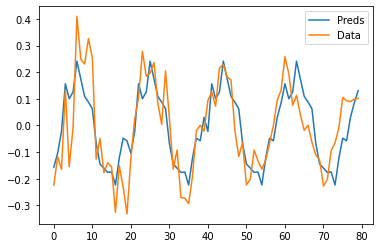

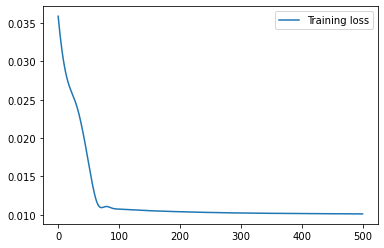

In [66]:
import util
from train import *
from generate_data import *
import matplotlib.pyplot as plt
%matplotlib inline

input_size = 20

# Data params
noise_var = 0
num_datapoints = 100
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

data = ARData(num_datapoints, num_prev=input_size, test_size=test_size, noise_var=noise_var, \
              coeffs=fixed_ar_coefficients[input_size])
X_train =data.X_train
y_train =data.y_train

hidden_size = 32
lstm_input_size = input_size
output_dim = 1
num_layers = 2
batch_size =num_train #80

X_train = X_train.reshape(input_size, -1, 1)
print(X_train.shape)
X_train = X_train.reshape(len(X_train), batch_size, 1)
print(X_train.shape)
X_train = X_train.swapaxes(0,2)
y_train = y_train.reshape(-1,1)

model = LSTM_RNN(lstm_input_size, hidden_size,  output_size=output_dim, num_layers=num_layers)

loss_fn = util.mse_loss_grad#(f,y)#torch.nn.MSELoss(size_average=False)

learning_rate = 1e-3
momentum = 0.9
#optimizer = SGD(model.parameters(),learning_rate,momentum)
optimizer = Adam(model.parameters(),learning_rate)
num_epochs = 500

print(X_train.shape)
hist = np.zeros(num_epochs)
for t in range(num_epochs):    
    model.hidden = model.init_hidden(batch_size)   
    y_pred = model(X_train) # Forward pass
    
    loss,grad = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss)        
    hist[t] = loss

    optimizer.zero_grad()  # Zero out gradient, else they will accumulate between epochs 
    model.backward(grad,X_train)# Backward pass   
    optimizer.step() # Update parameters
    
plt.plot(y_pred, label="Preds")
plt.plot(y_train, label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

### 7.10.3 双向循环神经网络

下面的RNNLayer表示了一个循环神经网络层。其构造函数的一个参数mode表示不同类型的循环神经网络单元，参数reverse表示这个神经网络层是正向的还是反向的。

In [67]:
from Layers import *
#from rnn import *
class RNNLayer(Layer):
    def __init__(self,mode,input_size, hidden_size,bias=True, batch_first=False,reverse=False):
        super(RNNLayer, self).__init__()
        self.mode = mode
        if mode == 'RNN_TANH':
            self.cell = RNNCell(input_size, hidden_size,bias,nonlinearity="tanh")
        elif mode == 'RNN_RELU':
            self.cell = RNNCell(input_size, hidden_size,bias,nonlinearity="relu")
        elif mode == 'LSTM':
            self.cell = LSTMCell(input_size, hidden_size,bias)
        elif mode == 'GRU':
            self.cell = GRUCell(input_size, hidden_size,bias)        
        self.reverse = reverse
        self.batch_first = batch_first
        self.zs = None
        
    def init_hidden(self, batch_size):
        #self.h = np.random.zeros(batch_size, self.hidden_dim)
        self.h = self.cell.init_hidden(batch_size)
        return self.h  
    
    def forward(self,input,h=None,batch_sizes = None):
        mode = self.mode
        if self.batch_first and batch_sizes is None:
            input = input.transpose(0, 1)
        seq_len,batch_size = input.shape[0], input.shape[1]   
        if h is None:  
            h = self.init_hidden(batch_size)
        self.h = h #h.copy()
        
        output = []
        zs=[] 
        hs = []
        steps = range(seq_len - 1, -1, -1) if self.reverse else range(seq_len)
        for t in steps:
            h = self.cell(input[t], h)
            #h,z = self.cell(input[t], h)
            #output.append(h) 
            if isinstance(h, tuple):
                h,z = h[0],h[1]
                if mode == 'LSTM' or mode == 'GRU':
                    zs.append(z)            
            hs.append(h)           
        
        self.hs = np.array(hs)
        output = [h[0] if isinstance(h, tuple) else h for h in self.hs]
        if mode == 'LSTM' or mode == 'GRU':
            self.zs = np.array(zs)
        return np.array(output),h
    
    def __call__(self,input,h=None,batch_sizes = None):
            return self.forward(input,h,batch_sizes)
        
    def backward(self, dhs,input):#,hs):     
        if False:
            if hs is None:
                hs,_ = self.forward(input)
        else:
            if self.hs is None:
                self.hs,_ = self.forward(input)
            hs = self.hs
        
        if False:
            if self.zs is  None:
                zs = hs
            else:
                zs = self.zs
        zs = self.zs if self.zs is not None else hs
      
        seq_len,batch_size = input.shape[0], input.shape[1]
        cell = self.cell
      
        if len(dhs)==len(hs):#.shape==hs.shape: #(seq,batch,hidden)          
            dinput = [None for i in range(seq_len)]
            steps = range(seq_len)   if self.reverse else range(seq_len - 1, -1, -1)
            t0 = seq_len - 1 if self.reverse else 0 
            dh = np.zeros_like(dhs[0]) #来自后一时刻的梯度
            for t in steps:  
                dh += dhs[t]          #后一时刻的梯度+当前时刻的梯度
                h_pre = self.h if t==t0 else hs[t-1]             
                dx,dh,_ = cell.backward(dh,zs[t],input[t],h_pre)                
              
                dinput[t] = dx
        return dinput

测试一下这个循环神经网络层类：

In [68]:
#test_LSTM="LSTM"
test_LSTM="GRU"
reverse = True
np.random.seed(1)

seq_len,batch_size,input_size,hidden_size = 5,3,4,6

if  test_LSTM=="RNN_TANH":
    rnn_ = RNNLayer("RNN_TANH",input_size, hidden_size,reverse = reverse)
elif test_LSTM=="GRU":
    rnn_ = RNNLayer('GRU',input_size, hidden_size,reverse = reverse)
else:
    rnn_ = RNNLayer('LSTM',input_size, hidden_size,reverse = reverse)

input  = np.random.randn(seq_len,batch_size,input_size) 
if reverse:
    input = input[::-1]

h0 = np.random.randn(batch_size, hidden_size)
c0 = np.random.randn(batch_size, hidden_size)

if  test_LSTM=="LSTM":
    output,hn= rnn_(input, (h0,c0))
else:
    output,hn= rnn_(input, h0)
print("output",output)
print("hn",hn)

#------test backward---    
do = np.random.randn(*output.shape)
dinput = rnn_.backward(do,input)#,rnn_.hs)#output)
print("dinput:",dinput)

output [[[ 0.98529853  0.54226394  0.87067973  0.11520828 -1.14269267
    0.42582622]
  [-0.13334087  0.04401171 -0.38530585  0.07464463 -0.20277516
   -0.09243082]
  [ 0.61308805  1.13157874 -0.37547481 -0.93738494 -0.72714967
   -0.13471224]]

 [[ 0.12271983  0.72744884  0.07499603  0.19624746 -0.97130027
    0.24047751]
  [-0.10838374  0.36549895 -0.53044892  0.21920808 -0.41894674
   -0.12161373]
  [ 0.5756363   0.66192994  0.34478068 -0.41911888 -0.36571545
   -0.21699069]]

 [[ 0.34313284  0.47791973 -0.07421252  0.20662352 -0.87125816
   -0.02436402]
  [ 0.09468831  0.31269736 -0.31467632  0.29748552 -0.54153618
   -0.2947006 ]
  [-0.02346966  0.63947901 -0.47209297 -0.04324441 -0.51834788
   -0.01982571]]

 [[ 0.19181091  0.43937988  0.01072851  0.30992938 -0.64633399
   -0.29797874]
  [ 0.30171129  0.34000351  0.21123339  0.26620739  0.0670621
   -0.44782343]
  [ 0.30767592  0.60060431 -0.19535927 -0.0969966  -0.56337432
    0.35244878]]

 [[ 0.11799502  0.29109034  0.43016514

在上述循环神经网络层的基础上，可以很方便地实现多层双向循环神经网络，RNNBase实现了一个双向多层循环神经网络：

In [69]:
from Layers  import *
class RNNBase_(Layer):
    __constants__ = ['mode', 'input_size', 'hidden_size', 'num_layers', 'bias',
                     'batch_first', 'dropout', 'bidirectional']

    def __init__(self, mode, input_size, hidden_size,
                 num_layers=1, bias=True, batch_first=False,
                 dropout=0., bidirectional=False):
        super(RNNBase_, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = float(dropout)
        self.bidirectional = bidirectional
        num_directions = 2 if bidirectional else 1
        self.num_directions = num_directions

        if not isinstance(dropout, float) or not 0 <= dropout <= 1 or \
                isinstance(dropout, bool):
            raise ValueError("dropout should be a number in range [0, 1] "
                             "representing the probability of an element being "
                             "zeroed")
        if dropout > 0 and num_layers == 1:
            warnings.warn("dropout option adds dropout after all but last "
                          "recurrent layer, so non-zero dropout expects "
                          "num_layers greater than 1, but got dropout={} and "
                          "num_layers={}".format(dropout, num_layers))

        if False:
            if mode == 'LSTM':
                gate_size = 4 * hidden_size
            elif mode == 'GRU':
                gate_size = 3 * hidden_size
            elif mode == 'RNN_TANH':
                gate_size = hidden_size
            elif mode == 'RNN_RELU':
                gate_size = hidden_size
            else:
                raise ValueError("Unrecognized RNN mode: " + mode)

        self.layers = []
        self.params = []
        self.grads = []
        self._all_weights = []
        for layer in range(num_layers):
            layer_input_size = input_size if layer == 0 else hidden_size
            for direction in range(num_directions):
                if direction==0:
                    rnnlayer = RNNLayer(mode,layer_input_size, hidden_size,reverse = False)
                else:
                    rnnlayer = RNNLayer(mode,layer_input_size, hidden_size,reverse = True)
                self.layers.append(rnnlayer)
                
                self.params+=   rnnlayer.cell.params
                self.grads+=   rnnlayer.cell.grads
    def init_hidden(self, batch_size):
        num_layers,num_directions = self.num_layers,self.num_directions
        selh.h0 = []
        for layer in self.layers:
            h0 = layer.init_hidden(batch_size)  
            selh.h0.append(h0)
        return self.h0
    
    def forward(self,input,h=None,batch_sizes = None):
        num_layers,num_directions = self.num_layers,self.num_directions  
        mode = self.mode  
        seq_len,batch_size = input.shape[0], input.shape[1]   
        if h is None:  
            h = self.init_hidden(batch_size)
        self.h = h #h.copy()
        hs = []
        hns = []                                
        for i in range(num_layers):  
            for j in range(num_directions):
                l=  i*num_directions+j     
                x = input if i == 0 else hs[l-num_directions]
                layer = self.layers[l]
                print(i,j,x.shape,h[l].shape)
                output,hn = layer(x,h[l])
                hs.append(output)
                hns.append(hn)
        self.hs = np.array(hs)
        #return output,hns
        output = self.hs[-1] if num_directions==1 else self.hs[-num_directions:]
        return output,np.array(hns)
        #return self.hs[-num_directions:],np.array(hns)
    
    def __call__(self,input,h=None,batch_sizes = None):
        return self.forward(input,h,batch_sizes)
    
    def backward(self, dhs,input):#,hs):  
        num_layers,num_directions = self.num_layers,self.num_directions
        if False:        
            if hs is None:
                hs,_ = self.forward(input)
        else:
            if self.hs is None:
                self.hs,_ = self.forward(input)
            hs = self.hs
        
        dhs = [dhs[j] for j in range(num_directions)] if num_directions==2 else [dhs]
        for i in reversed(range(num_layers)):  
            for j in (range(num_directions)):
                l=  i*num_directions+j   
                layer = self.layers[l]
                if i==0:
                    x = input
                else:
                    x = self.layers[l-num_directions].hs
                dhs[j] = layer.backward(dhs[j],x)
        
        return dhs

测试一下这个RNNBase_类：

In [70]:
import numpy  as np
np.random.seed(1)
reverse = False
num_layers = 2

seq_len,batch_size,input_size,hidden_size = 5,3,4,6

input = np.random.randn(seq_len,batch_size,input_size) 
test_LSTM = 'GRU'
if  test_LSTM=="RNN_TANH":
    rnn = RNNBase_("RNN_TANH",input_size,hidden_size,num_layers)
elif test_LSTM=="GRU":
    rnn = RNNBase_('GRU',input_size,hidden_size,num_layers)
else:
    rnn = RNNBase_('LSTM',input_size,hidden_size,num_layers)
    
h_0 = np.random.randn(num_layers, batch_size, hidden_size) 
output, hn = rnn(input, h_0)
print("output.shape",output.shape)  #(seq_len,batch_size,hidden_size)
print("output",output) 

do = np.random.randn(*output.shape)
dinput = rnn.backward(do,input)
print("dinput:",dinput)

0 0 (5, 3, 4) (3, 6)
1 0 (5, 3, 6) (3, 6)
output.shape (5, 3, 6)
output [[[ 3.24486260e-01  6.56674130e-01  8.68435304e-01  5.09315941e-01
    5.29784714e-01 -1.05821617e+00]
  [-4.45235395e-01 -8.78507584e-04  4.82631427e-03  1.92588270e-02
   -2.76288768e-01 -1.64919319e-01]
  [-1.18117119e-01  6.58384960e-01 -5.01438389e-01  2.11906306e-01
    7.13512787e-01 -1.10509111e-01]]

 [[ 1.28929605e-01  3.34295888e-01  8.06758802e-01 -1.71076528e-02
    5.93009642e-01 -8.17782989e-01]
  [-5.68243320e-01 -2.31040963e-01  8.08523747e-02 -6.52589763e-02
    1.64704303e-01 -2.64589517e-01]
  [ 2.41632617e-02  2.03820943e-01 -5.26430939e-01 -1.68229509e-01
    5.49005106e-01 -6.66190458e-02]]

 [[-9.59243983e-02  1.39907427e-01  6.87706734e-01 -1.99017474e-01
    6.20206686e-01 -6.20928098e-01]
  [-5.70379783e-01 -2.27599285e-01  2.93622403e-02 -6.17578519e-02
    3.58629218e-01 -1.63406067e-01]
  [-1.32293952e-01 -8.84043163e-02 -4.81944935e-01 -1.72222810e-01
    4.80312719e-01 -1.44052329e-0

## 7.11 序列到序列（seq2seq）模型

### 7.11.2 Seq2Seq模型的实现

下面的编码器EncoderRNN就是一个GRU神经网络，和前面的GRU类唯一不同的就是添加了一个辅助函数 word2vec()，将单词索引序列word_indices_input转化为one-hot向量，EncoderRNN就是一个GRU，因此其构造函数的参数和GRU的参数是一样的，input_size, hidden_size分别表示输入数据的长度和隐状态向量的长度。

In [ ]:
#from rnn import *
def one_hot(size,indices,expend = False):
    x =  np.eye(size)[indices.reshape(-1)]
    if expend:
        x = np.expand_dims(x, axis=1) 
    return x

class EncoderRNN(object):
    def __init__(self, input_size, hidden_size,num_layers = 1):
        super(EncoderRNN, self).__init__()
        self.input_size,self.hidden_size = input_size,hidden_size
        self.num_layers = num_layers
        #self.embedding = Embedding(input_size, hidden_size)
        self.gru = GRU(input_size, hidden_size,1)

    def word2vec(self,word_indices_input):
        return one_hot(self.input_size,word_indices_input,True)  
    
    def forward(self, word_indices_input, hidden):
        #self.encode_input = one_hot(self.input_size,word_indices_input,True) 
        self.encode_input =self.word2vec(word_indices_input)       
        output, hidden = self.gru(self.encode_input, hidden)       
        return output, hidden
      
    def __call__(self,word_indices_input, hidden):
        return self.forward(word_indices_input, hidden)
    
    def initHidden(self,batch_size=1):       
        return   np.zeros((self.num_layers, batch_size, self.hidden_size))      
    
    def parameters(self):
        return self.gru.parameters()
 
    def backward(self,dhs): 
        dinput,dhidden = self.gru.backward(dhs,self.encode_input) 

解码器DecoderRNN类的代码如下：

In [ ]:
class  DecoderRNN(object):
    def __init__(self,input_size,hidden_size, output_size,num_layers=1,teacher_forcing_ratio = 0.5):
       # super(DecoderRNN, self).__init__()    
        super().__init__()    
        self.input_size = input_size
        self.hidden_size = hidden_size       
        self.num_layers = num_layers   
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
        self.gru = GRU(input_size,hidden_size,num_layers)
        self.out = Dense(hidden_size, output_size)
        
        self.layers = [self.gru,self.out]        
        self._params = None        

    def initHidden(self,batch_size=1):      
        self.h_0 =  np.zeros((self.num_layers, batch_size, self.hidden_size))
    
    def word2vec(self,input_t):
        return one_hot(self.input_size,input_t,True)
    
    def forward_step(self, input_t, hidden):        
        gru_input = self.word2vec(input_t)        
        self.input.append(gru_input) 
        output_hs, hidden = self.gru(gru_input,hidden)
        output = self.out(output_hs[0])        
        return output,hidden,output_hs[0]     
   
    def forward(self,input_tensor,hidden):   
        teacher_forcing_ratio = self.teacher_forcing_ratio
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        #use_teacher_forcing = True
        self.input = []        
        
        output_hs = []
        output = []
        hidden_t = hidden
        h_0 = hidden.copy()
        
        input_t = np.array([SOS_token])
        #input_seq = []       
        hs = []
        zs = []
     
        target_length = input_tensor.shape[0]
        for t in range(target_length):
           # input_seq.append(input_t[0])        
           # print("type(input_t),input_t",type(input_t),input_t)
            
            output_t, hidden_t,output_hs_t = self.forward_step(
                input_t, hidden_t)
           
            #保存每一时刻的计算结果
            hs.append(self.gru.hs) #隐状态
            zs.append(self.gru.zs) #中间变量            
            output_hs.append(output_hs_t)
            output.append(output_t)
           
            if use_teacher_forcing:
                input_t = input_tensor[t]  # Teacher forcing
            else:             
                input_t = np.argmax(output_t)  #最大概率
                if input_t== EOS_token:
                    break 
                input_t = np.array([input_t])
         
        output = np.array(output)
        self.output_hs = np.array(output_hs)
        self.h_0 = h_0         
        self.hs = np.concatenate(hs, axis=1)
        self.zs = np.concatenate(zs, axis=1)
        
        #self.input_seq = input_seq        
        #return  output,input_seq
        return  output    
    
    def __call__(self, input, hidden):
        return self.forward(input, hidden)       
    
    def evaluate(self, hidden,max_length):
        # input:(1, batch_size=1, input_size)  
        input = np.array([SOS_token])
        decoded_word_indices = []
        for t in range(max_length):         
            output,hidden,_ = self.forward_step(input, hidden)
            output = np.argmax(output)         
            if output==EOS_token:
                break;
            else:           
                decoded_word_indices.append(output)
                input = np.array([output])
                
        return decoded_word_indices
        #return  indexToSentence(output_lang,decoded_words)
        #return  indexToSentence(output_verb,decoded_words)       
    
    def backward(self,dZs):
        dhs = []
        #output_hs,input_seq = self.output_hs,self.input_seq       
        output_hs = self.output_hs
        input = np.concatenate(self.input,axis=0)        
        
        for i in range(len(input)):
            self.out.x = output_hs[i]
            dh = self.out.backward(dZs[i])
            dhs.append(dh)
        dhs = np.array(dhs)
        
        self.gru.hs = self.hs
        self.gru.zs = self.zs
        self.gru.h = self.h_0
      
        dinput,dhidden = self.gru.backward(dhs,input) 
        return dinput,dhidden 
    
  #  def backward_dh(self,dZ):
  #      dh = self.out.backward(dZ)
  #      return dh 
    
    def parameters(self):
        if self._params is None:
            self._params = []
            for layer in self.layers:
                for  i, _ in enumerate(layer.params):  
                    self._params.append([layer.params[i],layer.grads[i]])  
        return self._params

下面的函数train()接受输入的一对输入输出序列input_tensor和target_tensor，以及编码器、解码器及其优化器encoder, decoder, encoder_optimizer, decoder_optimizer，还有用于计算模型损失的函数loss_fn和正则项系数reg。train()对模型进行一次模型参数的训练更新，先根据input_tensor计算编码器的输出encoder_output, encoder_hidden，然后将最后时刻的隐状态encoder_hidden作为解码器的输入，并和target_tensor一起用于计算解码器最终的预测输出output。然后根据这个预测的输出output和target计算交叉熵损失和该损失关于output的梯度grad，接着用decoder.backward(grad)对解码器反向求导，输出的是关于编码器的输出encoder_hidden的梯度dhidden，根据这个梯度继续对编码器进行反向求导。最后更新模型参数。在更新模型参数前，可以用clip_grad_norm_nn对梯度进行裁剪，防止梯度爆炸。

In [ ]:
def train_step(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn,reg,max_length=0):
    clip = 5.
  #  encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.shape[0] #input_tensor.size(0)
    
    loss = 0
    encode_input = input_tensor    
    encoder_output, encoder_hidden = encoder(encode_input, None)   
    decoder_hidden = encoder_hidden
    #output,input_seq = decoder(target_tensor, decoder_hidden) 
    output = decoder(target_tensor, decoder_hidden) 
    
    target = target_tensor.reshape(-1,1)
    if output.shape[0]!= target.shape[0]:       
        target = target[:output.shape[0],:]      
    loss,grad = loss_fn(output, target)    
    loss /=(output.shape[0])
    
    dinput,dhidden = decoder.backward(grad)
    encoder.backward(dhidden[0]) #,encode_input)
  
    if reg is not None:
        loss+=encoder_optimizer.regularization(reg)
        loss+=decoder_optimizer.regularization(reg)

    util.clip_grad_norm_nn(encoder_optimizer.parameters(),clip,None)
    util.clip_grad_norm_nn(decoder_optimizer.parameters(),clip,None)
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss
    #return loss.item() / target_length

迭代调用train()函数可以迭代的更新模型参数。函数trainIters()完成这个过程，并在迭代过程中可以输出中间的一些训练结果模型，如输出训练误差和验证误差。

In [ ]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

def timeSince(start):
    now = time.time()
    s = now - start  
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def trainIters(encoder, decoder, encoder_optimizer,decoder_optimizer,train_pairs,valid_pairs,print_every=1000, plot_every=100, reg =None):
    start = time.time()
    valid_losses = []
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every    
   
#    training_pairs = [tensorsFromPair(random.choice(train_pairs))      for i in range(n_iters)]
    training_pairs = train_pairs
 
    #criterion = nn.CrossEntropyLoss() #nn.NLLLoss()
    loss_fn =  util.rnn_loss_grad
    
    for iter in range(1, n_iters + 1):        
        pair = training_pairs[iter - 1]
        input_tensor,target_tensor = pair[0],pair[1]     
       
        loss = train_step(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, loss_fn,reg)
        if loss is None: continue
       
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
         #   plot_losses.append(loss)
            plot_loss_total = 0
            
            plt.plot(plot_losses)
            
            valid_losses.append(validation_loss(encoder, decoder, valid_pairs,20,reg))
            plt.plot(valid_losses)           
            plt.legend(["train_losses","valid_losses"])
            plt.show()

def validation_loss(encoder, decoder, valid_pairs,validation_size = None,reg =None):    
    if validation_size is not None:
        #valid_pairs = [tensorsFromPair(random.choice(valid_pairs))for i in range(validation_size)]
        valid_pairs = [random.choice(valid_pairs) for i in range(validation_size)]
    total_loss = 0
    loss_fn =  util.rnn_loss_grad
    
    teacher_forcing_ratio = decoder.teacher_forcing_ratio 
    decoder.teacher_forcing_ratio = 1.1
    for pair in valid_pairs:
        encode_input = pair[0]   
        target_tensor = pair[1]   
        
        encoder_output, encoder_hidden = encoder(encode_input, None)   
        decoder_hidden = encoder_hidden
        output = decoder(target_tensor, decoder_hidden) 

        
        target = target_tensor.reshape(-1,1)
        if output.shape[0]!= target.shape[0]:
            target = target[:output.shape[0],:]        
        loss,grad = loss_fn(output, target)    
        loss /=(output.shape[0])
       
        if reg is not None:
            params = encoder.parameters()+decoder.parameters()
            reg_loss =0
            for p,grad in params:            
                 reg_loss+= np.sum(p**2)
            loss += reg*reg_loss
    
        total_loss += loss
        
    decoder.teacher_forcing_ratio = teacher_forcing_ratio 
    return total_loss/len(valid_pairs)

### 7.11.3 字符级机器翻译的Seq2Seq

类ChVerb用于表示一种语言的字符单词表，即其中记录了有哪些字符、每个字符和其在字符单词表中的索引的对应关系。其中用'\t','\n'分别表示特殊的开始字符和结束字符，它们对应的单词表索引分别为0和1。

#### 1. 字符单词表

In [ ]:
SOS_token = 0
EOS_token = 1

class ChVerb:
    def __init__(self, name):
        self.name = name
       
        self.char2index = {'\t':0, '\n':1}      
        self.index2char = {0: '\t', 1: '\n'}
        self.n_chars = 2  # Count SOS and EOS

    def addChars(self, chars):
        for char in chars:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars           
            self.index2char[self.n_chars] = char
            self.n_chars += 1  

#### 2 读取训练样本、构建字符单词表

In [ ]:
import numpy as np
import random
import re
import unicodedata
random.seed(1)

#Normalize every sentence
#you will normalize it to lower case,
#remove all non-character
#convert to ASCII from Unicode
#split the sentences, so you have each word in it.

def unicodeToAscii(sentence):
    return ''.join(
        c for c in unicodedata.normalize('NFD', sentence)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_sentence(sentence):    
    sentence = unicodeToAscii(sentence.lower().strip())
    #return sentence
    sentence = re.sub(r"([.!?])", r" \1", sentence)
    sentence = re.sub(r"[^a-zA-Z.!?]+", r" ", sentence)
    return sentence


MAX_LENGTH  =10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):  
    return  True
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang_from, lang_to, reverse=False):   
     # construct verb   
    if reverse:
        in_verb = ChVerb(lang_to)
        out_verb = ChVerb(lang_from)
    else:
        in_verb = ChVerb(lang_from)
        out_verb = ChVerb(lang_to)
        
    #read pairs    
    data_path = 'data/%s-%s/%s.txt' % (lang_to, lang_from,lang_to) 
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
        pairs = [[normalize_sentence(s) for s in l.split('\t')][:2] for l in lines]
        
        if reverse:
            pairs = [list(reversed(p)) for p in pairs]

    pairs = filterPairs(pairs)
    for pair in pairs:        
        in_verb.addChars(pair[0])
        out_verb.addChars(pair[1])
       
    return in_verb, out_verb, pairs


in_verb, out_verb, pairs = prepareData( 'eng','fra',True) # False)

print("Read %s sentence pairs" % len(pairs))  
print("Counted chars:")
print(in_verb.name, in_verb.n_chars)
print(out_verb.name, out_verb.n_chars)
for i in range(5):
    print(random.choice(pairs))
print(pairs[3])

下面的代码在这些训练样本的文字句子的字符单词和单词表索引进行互相转换：

In [ ]:
def indexToSentence(verb, indexes):
    sentense = [verb.index2char[idx] for idx in indexes]    
    return ''.join(sentense)

def indexesFromSentence(verb, sentence):
    return [verb.char2index[char] for char in sentence]
    
def tensorFromSentence(verb, sentence):
    indexes = indexesFromSentence(verb, sentence)
    indexes.append(EOS_token)
    return np.array(indexes).reshape(-1,1)
#    return np.array(indexes,dtype = np.int64).reshape(-1,1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(in_verb, pair[0])
    target_tensor = tensorFromSentence(out_verb, pair[1])
    return (input_tensor, target_tensor)

print(pairs[3])
en_input, de_target = tensorsFromPair(pairs[3]) #random.choice(pairs))

print(en_input.shape)
print(de_target.shape)
print(en_input)
print(de_target)

#### 3. 训练字符级的Seq2Seq模型

In [ ]:
from train import *
from Layers import *
from rnn import *
import util

hidden_size = 50 #256 
num_layers = 1

clip = 5.#50.
learning_rate = 0.1
decoder_learning_ratio = 1.0 
teacher_forcing_ratio =0.5

encoder = EncoderRNN(in_verb.n_chars, hidden_size)
decoder = DecoderRNN(out_verb.n_chars,hidden_size,out_verb.n_chars,num_layers,teacher_forcing_ratio)

momentum = 0.5
decay_every  =1000
encoder_optimizer = SGD(encoder.parameters(), learning_rate, momentum,decay_every)
decoder_optimizer = SGD(decoder.parameters(), learning_rate*decoder_learning_ratio, momentum,decay_every)

reg= None#1e-2

if True:
    pairs = pairs[:80000]

np.random.shuffle(pairs)
train_n = (int)(len(pairs)*0.98)
train_pairs = pairs[:train_n]
valid_pairs = pairs[train_n:]

n_iters = 50000
print_every, plot_every = 100,100  #10,10
idx_train_pairs = [tensorsFromPair(random.choice(train_pairs))      for i in range(n_iters)]
idx_valid_pairs  =  [tensorsFromPair(pair)  for pair in valid_pairs]
trainIters(encoder, decoder,encoder_optimizer,decoder_optimizer,idx_train_pairs,idx_valid_pairs,print_every, plot_every,reg)

可以用训练的模型进行语言翻译，将待翻译的语言的单词序列（句子）输入到编码器产生一个输出的上下文信息，该信息输入到解码器，解码器从初始时刻的输入SOS和这个上下文新产生翻译的单词序列（句子）。

In [ ]:
MAX_LENGTH = 60
def evaluate(encoder, decoder,in_vocab,out_vocab,sentence, max_length=MAX_LENGTH):    
    #batch_size  = 1  
    #encoder_hidden = encoder.init_hidden(batch_size)    
    #encode_input = one_hot(input_verb.n_chars,en_input,True)
    encode_input = tensorFromSentence(in_vocab,sentence)
    encoder_output, encoder_hidden = encoder(encode_input, None)
 
    output_sentence =  decoder.evaluate(encoder_hidden,max_length)     
    output_sentence = indexToSentence(out_vocab,output_sentence)
    return output_sentence

随机选择几个输入句子，用evaluate预测翻译的句子：

In [ ]:
indices = np.random.randint(len(pairs), size=3)
for i in indices:
    pair = pairs[i]
    print(pair)
    sentence = pair[0]   
    sentence = evaluate(encoder, decoder,in_verb,out_verb, sentence)
    print(sentence)